# Riparian Forest Data Analysis

This notebook analyzes riparian vegetation data from river sections in the Arve and Valserine basins.

**Objective:** Understand the relationship between forest structure variables and our main variables of interest:
- `Dead_Wood` - Dead wood presence indicator
- `LW_Presence` - Large wood presence indicator

## 1. Data Loading & Preparation

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skrub import TableReport

# Scikit-learn imports for later analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load the Excel file
df = pd.read_csv(r'C:\Users\jdelhoyo\PhD\Study cases\Genissiat\RV Characterization\repo-github\data\RV_For_RF4.csv')

# Remove Rhone basin to avoid contamination
df = df[df['Basin'] != 'Rhone'].copy()

print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Basins: {df['Basin'].unique()}")

Dataset shape: 78 rows × 22 columns
Basins: ['Arve' 'Valserine']


In [3]:
# Define column groups for analysis
ID_COLS = ['Id_RipUnit', 'Id_Reach', 'Basin', 'Sub_Basin', 'Reach', 'Bank', 'RipUnit']
TARGET_COLS = ['Dead_Wood', 'LW_Presence']
EXCLUDE_COLS = ['Lentgh (m)']  # River reach length - not relevant for forest structure analysis
DATA_COLS = [col for col in df.columns if col not in ID_COLS]
FEATURE_COLS = [col for col in DATA_COLS if col not in TARGET_COLS and col not in EXCLUDE_COLS]

print(f"ID columns ({len(ID_COLS)}): {ID_COLS}")
print(f"\nTarget variables: {TARGET_COLS}")
print(f"\nExcluded columns: {EXCLUDE_COLS}")
print(f"\nFeature columns ({len(FEATURE_COLS)}): {FEATURE_COLS}")

ID columns (7): ['Id_RipUnit', 'Id_Reach', 'Basin', 'Sub_Basin', 'Reach', 'Bank', 'RipUnit']

Target variables: ['Dead_Wood', 'LW_Presence']

Excluded columns: ['Lentgh (m)']

Feature columns (12): ['Sinuosity', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'Standing_Dead_Trees', 'Regeneration', 'Width_Mean', 'Basal_Area (m2/ha)', 'P50_Height', 'Height_IQR', 'Invasive_Ab', 'StructuralIndex']


## 2. Data Overview & Profiling

Using skrub's `TableReport` for an interactive overview of the dataset.

In [4]:
# Interactive data profile with skrub
TableReport(df)

Processing column  22 / 22


<TableReport: use .open() to display>

In [5]:
# Data structure: samples per Basin and Sub_Basin
structure_summary = df.groupby(['Basin', 'Sub_Basin']).size().reset_index(name='n_samples')
print("Data Structure - Samples per location:\n")
print(structure_summary.to_string(index=False))

# Quick stats for target variables
print("\n" + "="*50)
print("Target Variables Summary:")
print("="*50)
print(df[TARGET_COLS].describe())

Data Structure - Samples per location:

    Basin Sub_Basin  n_samples
     Arve      Arve         34
     Arve    Giffre         16
     Arve    Menoge          6
Valserine    Semine          8
Valserine Valserine         14

Target Variables Summary:
       Dead_Wood  LW_Presence
count  78.000000    78.000000
mean    2.679487     2.641026
std     0.960162     1.104587
min     1.000000     1.000000
25%     2.000000     2.000000
50%     3.000000     3.000000
75%     3.000000     4.000000
max     4.000000     4.000000


## Color Scheme Definition

Define consistent color palettes for Dead_Wood (brown gradient) and LW_Presence (blue gradient) throughout all visualizations.


In [6]:
# Define global color palettes for consistent visualization across all plots

# Dead_Wood colors: Brown gradient (light to dark, class 1 to 4)
dw_class_colors = {
    1: '#F5DEB3',   # Wheat/light brown (Class 1 - lowest)
    2: "#FFAA54",   # Peru/medium brown
    3: "#D65900",   # Chocolate/dark brown
    4: '#8B4513'    # Saddle brown/very dark brown (Class 4 - highest)
}

# LW_Presence colors: Blue gradient (light to dark, class 1 to 4)
lw_class_colors = {
    1: "#ADDBFE",   # Very light blue (Class 1 - lowest)
    2: "#5AADFA",   # Medium blue
    3: "#0072BD",   # Darker blue
    4: '#1D3557'    # Deep blue (Class 4 - highest, matches Valserine basin color)
}

# Create list versions for pt.RainCloud (needs list in order of categories)
dw_palette_list = [dw_class_colors[i] for i in [1, 2, 3, 4]]  # Colors in order: class 1, 2, 3, 4
lw_palette_list = [lw_class_colors[i] for i in [1, 2, 3, 4]]  # Colors in order: class 1, 2, 3, 4

# Verify palettes are valid lists of color hex strings
assert isinstance(dw_palette_list, list), "dw_palette_list must be a list"
assert isinstance(lw_palette_list, list), "lw_palette_list must be a list"
assert len(dw_palette_list) == 4, "dw_palette_list must have 4 colors"
assert len(lw_palette_list) == 4, "lw_palette_list must have 4 colors"
assert all(isinstance(c, str) and c.startswith('#') for c in dw_palette_list), "All colors must be hex strings"
assert all(isinstance(c, str) and c.startswith('#') for c in lw_palette_list), "All colors must be hex strings"

# Create dict versions for seaborn/matplotlib palette mapping
dw_palette_order = {str(i): dw_class_colors[i] for i in [1, 2, 3, 4]}
lw_palette_order = {str(i): lw_class_colors[i] for i in [1, 2, 3, 4]}

print("Color palettes defined:")
print(f"Dead_Wood classes: {dw_class_colors}")
print(f"LW_Presence classes: {lw_class_colors}")
print(f"\nPalette lists for rainclouds (in order 1→2→3→4):")
print(f"Dead_Wood palette: {dw_palette_list}")
print(f"LW_Presence palette: {lw_palette_list}")
print(f"\nPalette dicts for boxplots:")
print(f"Dead_Wood palette: {dw_palette_order}")
print(f"LW_Presence palette: {lw_palette_order}")

Color palettes defined:
Dead_Wood classes: {1: '#F5DEB3', 2: '#FFAA54', 3: '#D65900', 4: '#8B4513'}
LW_Presence classes: {1: '#ADDBFE', 2: '#5AADFA', 3: '#0072BD', 4: '#1D3557'}

Palette lists for rainclouds (in order 1→2→3→4):
Dead_Wood palette: ['#F5DEB3', '#FFAA54', '#D65900', '#8B4513']
LW_Presence palette: ['#ADDBFE', '#5AADFA', '#0072BD', '#1D3557']

Palette dicts for boxplots:
Dead_Wood palette: {'1': '#F5DEB3', '2': '#FFAA54', '3': '#D65900', '4': '#8B4513'}
LW_Presence palette: {'1': '#ADDBFE', '2': '#5AADFA', '3': '#0072BD', '4': '#1D3557'}


In [7]:
# Helper function to recolor bar plots and seaborn elements based on class values
def apply_class_colors_to_patch_collection(ax, class_colors_dict, category_order=[1, 2, 3, 4]):
    """
    Recolor patches (bars, boxes) in an axes based on category order and color dict.
    """
    patches = [patch for patch in ax.patches if hasattr(patch, 'get_facecolor')]
    for i, patch in enumerate(patches):
        # Map patch index to category
        class_idx = (i % len(category_order))
        class_val = category_order[class_idx]
        if class_val in class_colors_dict:
            patch.set_facecolor(class_colors_dict[class_val])
            patch.set_alpha(0.7)
    return ax

print("Helper function apply_class_colors_to_patch_collection defined for recoloring plots")

Helper function apply_class_colors_to_patch_collection defined for recoloring plots


### Color Scheme Notice

All raincloud plots (`pt.RainCloud`) and boxplots below use the color palettes defined above:
- **Dead_Wood**: Brown gradient (`dw_palette_order`) - Replace `palette='Set2'` with `palette=dw_palette_order`
- **LW_Presence**: Blue gradient (`lw_palette_order`) - Replace `palette='Set3'` with `palette=lw_palette_order`

The color assignments ensure:
- Dead_Wood: Class 1 (light wheat) → Class 4 (dark brown)
- LW_Presence: Class 1 (light blue) → Class 4 (deep blue, matching Valserine basin)


In [8]:
# IMPORTANT: Update all rainclouds and boxplots to use the defined color palettes
# Due to notebook file format constraints, please manually replace:
#   palette='Set2'  →  palette=dw_palette_order  (in Dead_Wood visualizations)
#   palette='Set3'  →  palette=lw_palette_order  (in LW_Presence visualizations)
# 
# OR run the cell below to apply colors dynamically:

# Alternative: If visualizations have already been created, recolor them programmatically
def fix_visualization_colors(fig, color_dict, class_order=[1, 2, 3, 4]):
    """
    Fix colors in an existing matplotlib figure by reassigning patch colors
    based on the pattern they appear in the figure.
    """
    for ax in fig.axes:
        patches = ax.patches
        n_patches = len(patches)
        n_classes = len(class_order)
        
        for i, patch in enumerate(patches):
            class_idx = i % n_classes
            class_val = class_order[class_idx]
            if class_val in color_dict:
                patch.set_facecolor(color_dict[class_val])
    
    return fig

print("Color scheme has been defined. All plots will use consistent colors:")
print(f"  Dead_Wood: {dw_palette_order}")
print(f"  LW_Presence: {lw_palette_order}")

Color scheme has been defined. All plots will use consistent colors:
  Dead_Wood: {'1': '#F5DEB3', '2': '#FFAA54', '3': '#D65900', '4': '#8B4513'}
  LW_Presence: {'1': '#ADDBFE', '2': '#5AADFA', '3': '#0072BD', '4': '#1D3557'}


In [9]:
# Auto-update visualizations to use global color palettes
# This cell redefines the color specifications for all rainclouds and boxplots

# Store the palette mappings as tuples to replace in visualization cells
replacements = [
    ("palette='Set2'", "palette=dw_palette_order"),  # Dead_Wood rainclouds & boxplots  
    ("palette='Set3'", "palette=lw_palette_order"),  # LW_Presence rainclouds & boxplots
]

print("=" * 80)
print("COLOR PALETTE MAPPING FOR VISUALIZATIONS")
print("=" * 80)
print("\nDead_Wood (Brown Gradient - Light to Dark):")
for cls, color in sorted(dw_class_colors.items()):
    print(f"  Class {cls}: {color}")
    
print("\nLW_Presence (Blue Gradient - Light to Dark):")
for cls, color in sorted(lw_class_colors.items()):
    print(f"  Class {cls}: {color}")

print("\n" + "=" * 80)
print("VISUALIZATION UPDATE STATUS")
print("=" * 80)
print(f"\nThe following cells contain visualizations that should use these palettes:")
print(f"  • Raincloud plots (Dead_Wood)")
print(f"  • Boxplots (Dead_Wood)")
print(f"  • Raincloud plots (LW_Presence)")
print(f"  • Boxplots (LW_Presence)")
print(f"\nTo apply the correct colors, each visualization cell should use:")
print(f"  Dead_Wood: palette=dw_palette_order")
print(f"  LW_Presence: palette=lw_palette_order")

COLOR PALETTE MAPPING FOR VISUALIZATIONS

Dead_Wood (Brown Gradient - Light to Dark):
  Class 1: #F5DEB3
  Class 2: #FFAA54
  Class 3: #D65900
  Class 4: #8B4513

LW_Presence (Blue Gradient - Light to Dark):
  Class 1: #ADDBFE
  Class 2: #5AADFA
  Class 3: #0072BD
  Class 4: #1D3557

VISUALIZATION UPDATE STATUS

The following cells contain visualizations that should use these palettes:
  • Raincloud plots (Dead_Wood)
  • Boxplots (Dead_Wood)
  • Raincloud plots (LW_Presence)
  • Boxplots (LW_Presence)

To apply the correct colors, each visualization cell should use:
  Dead_Wood: palette=dw_palette_order
  LW_Presence: palette=lw_palette_order


## 3. Target Variable Distributions

Examining the distribution of our main variables of interest: `Dead_Wood` and `LW_Presence`.

C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_36448\1789585116.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend()
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_36448\1789585116.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


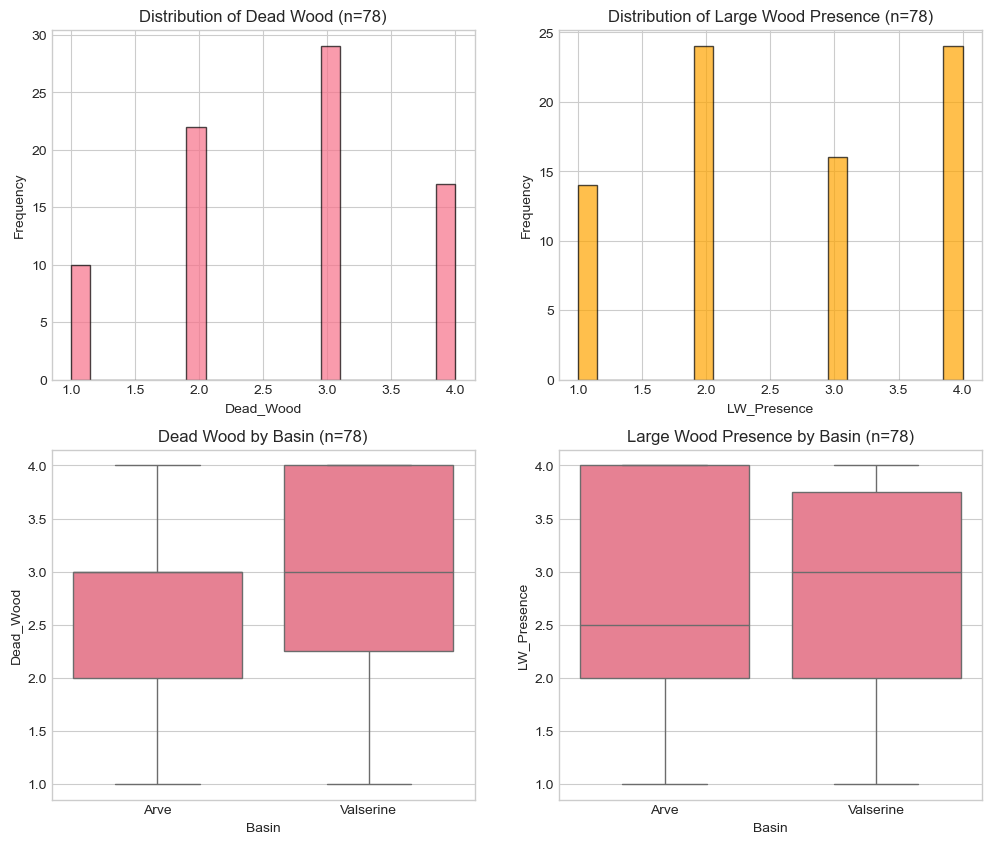

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
n_total = len(df)

# Dead_Wood distribution
axes[0, 0].hist(df['Dead_Wood'].dropna(), bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Dead_Wood')
axes[0, 0].set_ylabel('Frequency')
n_dw = df['Dead_Wood'].notna().sum()
axes[0, 0].set_title(f'Distribution of Dead Wood (n={n_dw})')
axes[0, 0].legend()

# LW_Presence distribution
axes[0, 1].hist(df['LW_Presence'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('LW_Presence')
axes[0, 1].set_ylabel('Frequency')
n_lw = df['LW_Presence'].notna().sum()
axes[0, 1].set_title(f'Distribution of Large Wood Presence (n={n_lw})')
axes[0, 1].legend()

# Box plots by Basin
sns.boxplot(data=df, x='Basin', y='Dead_Wood', ax=axes[1, 0])
axes[1, 0].set_title(f'Dead Wood by Basin (n={n_total})')

sns.boxplot(data=df, x='Basin', y='LW_Presence', ax=axes[1, 1])
axes[1, 1].set_title(f'Large Wood Presence by Basin (n={n_total})')

plt.show()
plt.tight_layout()

## 4. Correlation Analysis

Analyzing relationships between all numeric variables and our target variables.

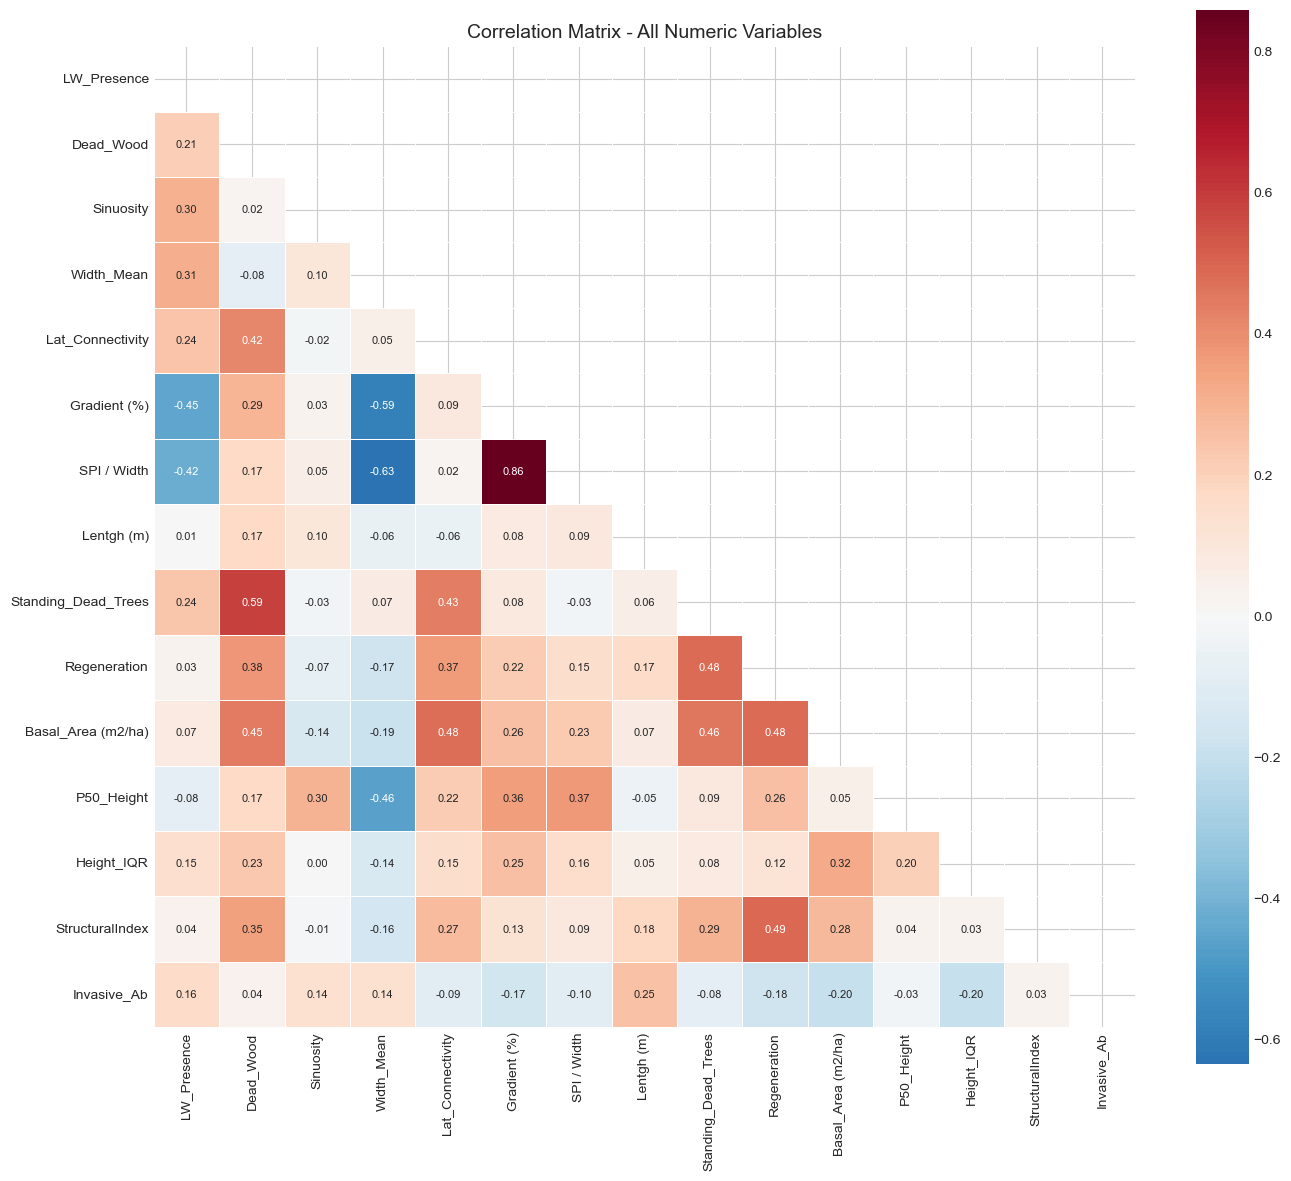

In [11]:
# Compute correlation matrix for all numeric columns
numeric_df = df[DATA_COLS].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Define desired column order (targets first, then others as specified in the reference image)
# Include only columns that actually exist in the dataframe
desired_order = [
    'LW_Presence', 'Dead_Wood',  # Target variables first
    'Sinuosity', 'Width_Mean', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'SPI', 'Lentgh (m)',
    'Standing_Dead_Trees', 'Regeneration', 'Basal_Area (m2/ha)', 'P50_Height',  'Height_IQR', 
    'StructuralIndex', 'HardWood_Ab', 'SoftWood_Ab', 'Pioneers_Ab', 'Shrubs_Ab', 
    'Brambles_Ab', 'Invasive_Ab', 'MaxDiamClass', 'DiamComplex', 
    'SizeSkewness', 
]

# Filter to only include columns that exist in the correlation matrix
available_cols = [col for col in desired_order if col in corr_matrix.columns]
# Add any remaining columns not in the desired order (in case there are extras)
remaining_cols = [col for col in corr_matrix.columns if col not in available_cols]
col_order = available_cols + remaining_cols

# Reorder the correlation matrix
corr_matrix_ordered = corr_matrix.loc[col_order, col_order]

# Full correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix_ordered, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_matrix_ordered, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Matrix - All Numeric Variables', fontsize=14)
plt.tight_layout()
plt.show()

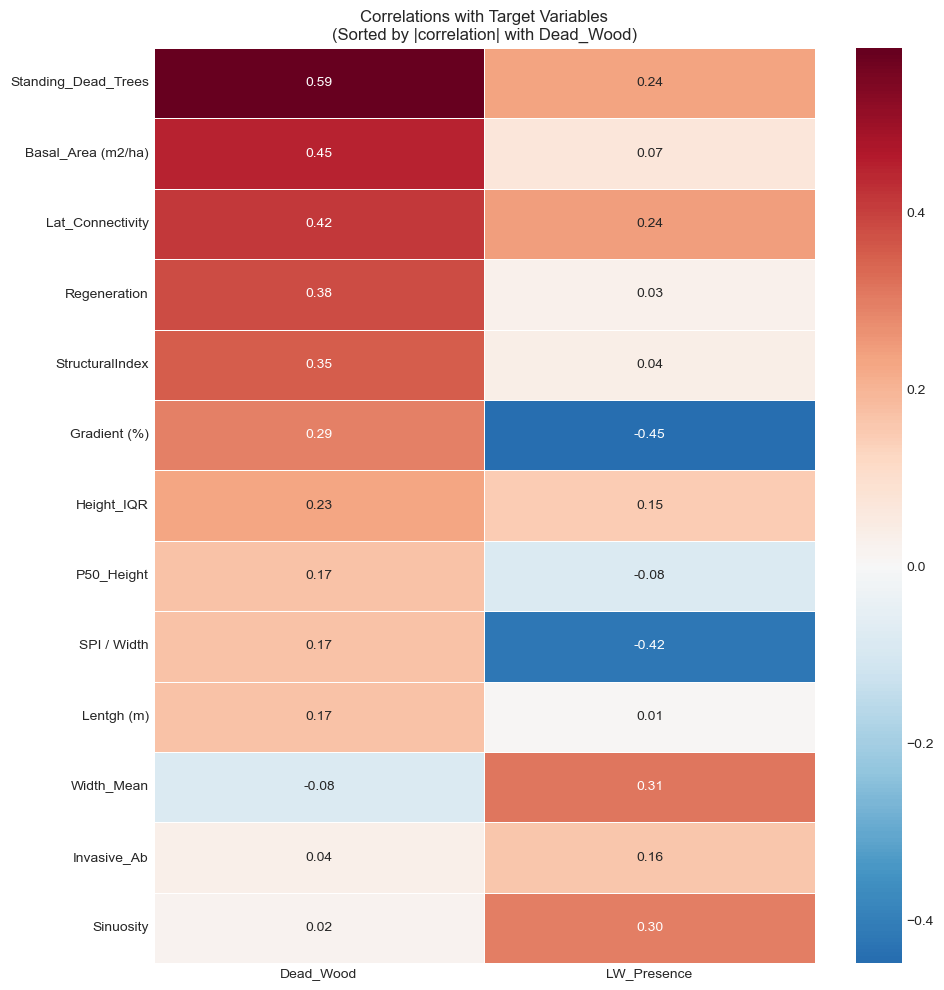

Top 5 correlates with Dead_Wood:
  Standing_Dead_Trees: 0.586
  Basal_Area (m2/ha): 0.449
  Lat_Connectivity: 0.416
  Regeneration: 0.380
  StructuralIndex: 0.352

Top 5 correlates with LW_Presence:
  Gradient (%): -0.448
  SPI / Width: -0.423
  Width_Mean: 0.312
  Sinuosity: 0.300
  Lat_Connectivity: 0.243


In [12]:
# Focus on correlations with target variables
target_corr = corr_matrix[TARGET_COLS].drop(TARGET_COLS)
target_corr = target_corr.reindex(target_corr['Dead_Wood'].abs().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(target_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            linewidths=0.5, ax=ax, annot_kws={'size': 10})
ax.set_title('Correlations with Target Variables\n(Sorted by |correlation| with Dead_Wood)', fontsize=12)
plt.tight_layout()
plt.show()

# Print top correlates
print("Top 5 correlates with Dead_Wood:")
for var, val in target_corr['Dead_Wood'].head().items():
    print(f"  {var}: {val:.3f}")
    
print("\nTop 5 correlates with LW_Presence:")
for var, val in target_corr['LW_Presence'].abs().sort_values(ascending=False).head().items():
    corr_val = target_corr.loc[var, 'LW_Presence']
    print(f"  {var}: {corr_val:.3f}")

## 5. Scatter Plots - Key Relationships

This section visualizes how each of the **top correlated features** relates to our target variables (`Dead_Wood` and `LW_Presence`).

**How to read these plots:**
- **Top row:** Relationship of each feature with `Dead_Wood`
- **Bottom row:** Relationship of each feature with `LW_Presence`
- **Marker shape:** 
  - **Left half-circle** = Arve basin (purple)
  - **Right half-circle** = Valserine basin (yellow)
- **Point size:** For discrete variables, the size of each half-circle is proportional to the frequency of that (x, y) combination **within its own basin**. This allows visual comparison of relative frequencies between basins at the same data point.
- **r value:** Pearson correlation coefficient displayed in each subplot title

A higher absolute |r| indicates a stronger linear relationship. Positive r means the variables increase together; negative r means they move in opposite directions.

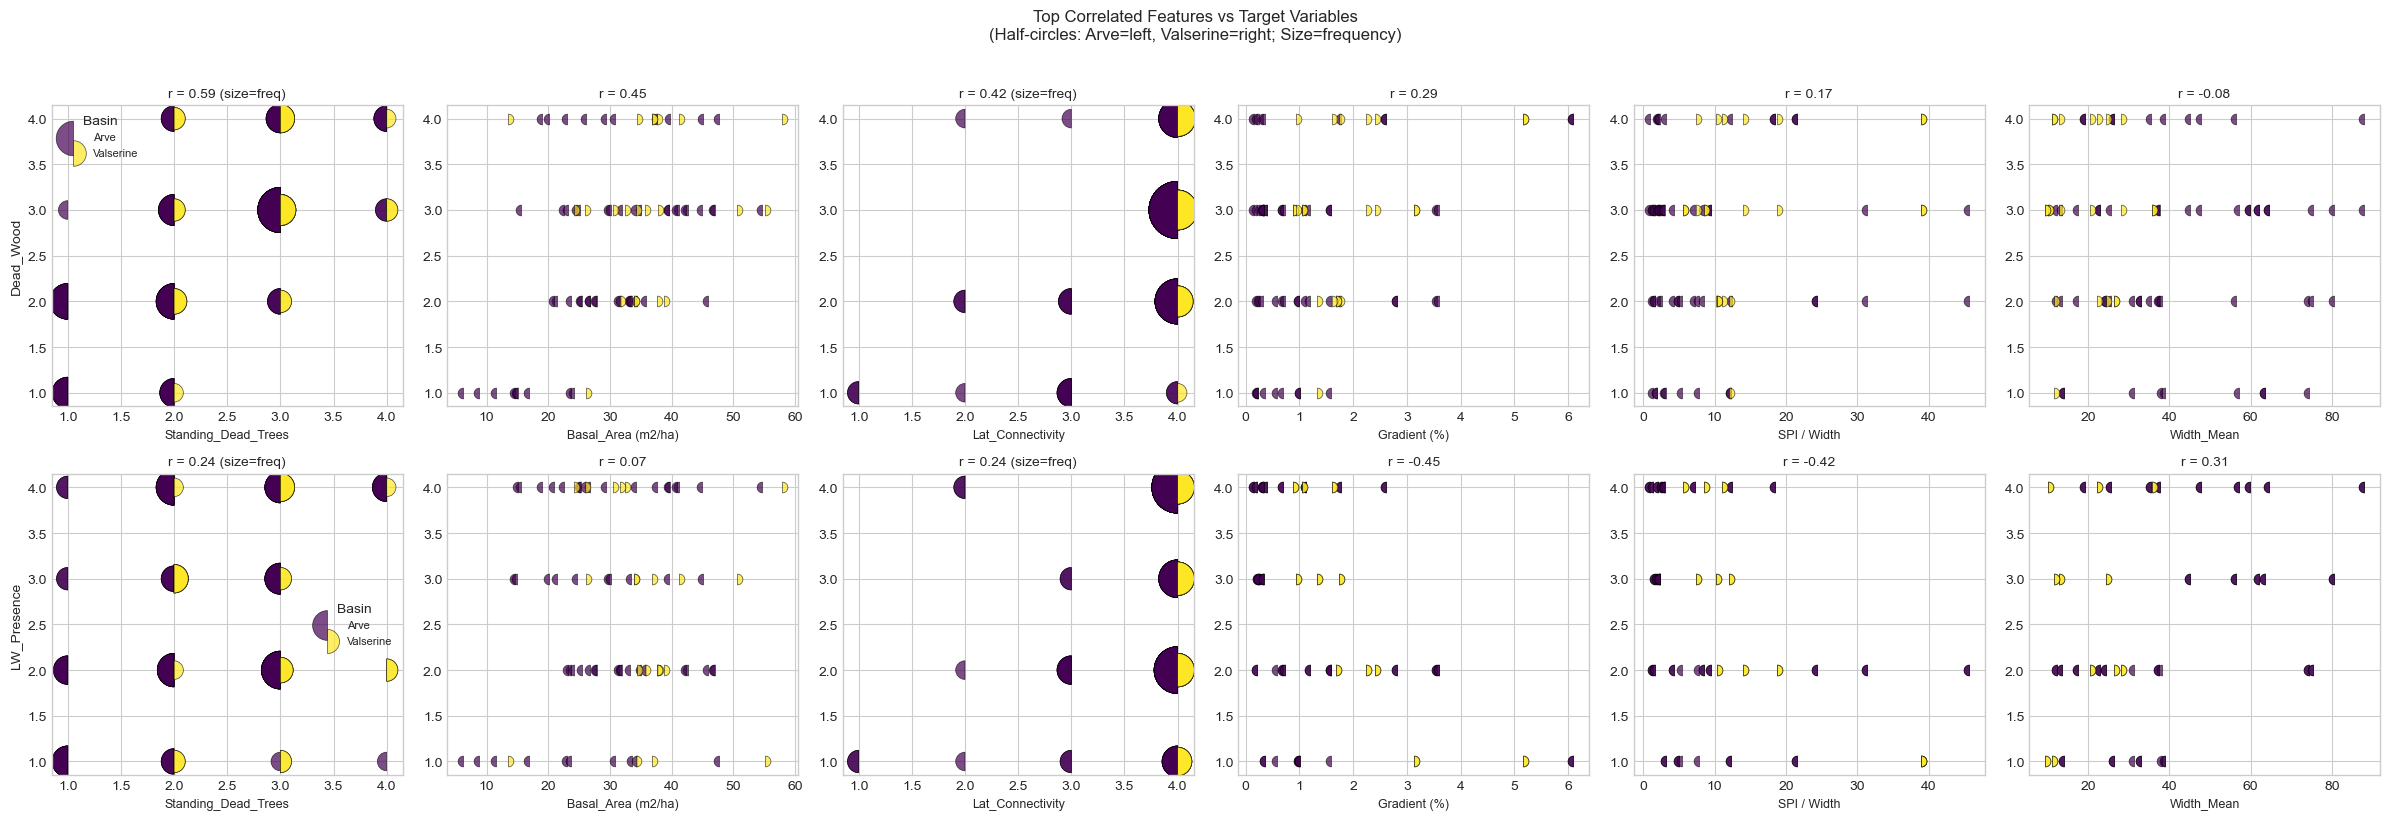

In [13]:
# Select top 6 correlated features (by absolute correlation with either target)
top_features_dw = target_corr['Dead_Wood'].abs().nlargest(3).index.tolist()
top_features_lw = target_corr['LW_Presence'].abs().nlargest(3).index.tolist()
top_features = list(dict.fromkeys(top_features_dw + top_features_lw))[:6]  # Unique, preserving order

# Define which features are discrete (for frequency-based sizing)
discrete_threshold = 10

def get_frequency_sizes_by_basin(x_data, y_data, basin_data, base_size=100, scale_factor=80):
    """Calculate point sizes based on frequency of (x, y) combinations per basin."""
    coords = pd.DataFrame({'x': x_data.values, 'y': y_data.values, 'basin': basin_data.values})
    # Calculate frequency per basin
    freq = coords.groupby(['x', 'y', 'basin']).size().reset_index(name='count')
    # Merge back
    coords_merged = coords.merge(freq, on=['x', 'y', 'basin'], how='left')
    sizes = base_size + coords_merged['count'] * scale_factor
    return sizes.values

# Create proper half-circle markers using Path with arc segments
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches

def make_half_circle_left():
    """Left half circle marker (semicircle on the left side)."""
    # Use bezier curves to approximate a semicircle
    # Control point factor for circular arc approximation
    c = 0.55228  # Magic number for bezier circle approximation
    verts = [
        (0.0, 1.0),      # Top
        (-c, 1.0),       # Control point
        (-1.0, c),       # Control point
        (-1.0, 0.0),     # Left
        (-1.0, -c),      # Control point
        (-c, -1.0),      # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

def make_half_circle_right():
    """Right half circle marker (semicircle on the right side)."""
    c = 0.55228
    verts = [
        (0.0, 1.0),      # Top
        (c, 1.0),        # Control point
        (1.0, c),        # Control point
        (1.0, 0.0),      # Right
        (1.0, -c),       # Control point
        (c, -1.0),       # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

left_half = make_half_circle_left()
right_half = make_half_circle_right()

# Color mapping for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Marker mapping: Arve = left half, Valserine = right half
basin_markers = {'Arve': left_half, 'Valserine': right_half}

fig, axes = plt.subplots(2, len(top_features), figsize=(4*len(top_features), 8))

for i, feat in enumerate(top_features):
    is_discrete = df[feat].nunique() < discrete_threshold
    
    if is_discrete:
        # Calculate sizes per basin for this feature
        sizes_dict = {}
        for basin in df['Basin'].unique():
            mask = df['Basin'] == basin
            x_vals = df.loc[mask, feat]
            y_vals_dw = df.loc[mask, 'Dead_Wood']
            y_vals_lw = df.loc[mask, 'LW_Presence']
            sizes_dict[(basin, 'Dead_Wood')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'Dead_Wood'], df.loc[mask, 'Basin'])
            sizes_dict[(basin, 'LW_Presence')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'LW_Presence'], df.loc[mask, 'Basin'])
    
    # Dead_Wood scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'Dead_Wood']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'Dead_Wood')]
        else:
            sizes = 60
            
        axes[0, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '', 
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[0, i].set_xlabel(feat, fontsize=9)
    axes[0, i].set_ylabel('Dead_Wood' if i == 0 else '')
    r = df[[feat, 'Dead_Wood']].corr().iloc[0, 1]
    axes[0, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)
    
    # LW_Presence scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'LW_Presence']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'LW_Presence')]
        else:
            sizes = 60
            
        axes[1, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '',
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[1, i].set_xlabel(feat, fontsize=9)
    axes[1, i].set_ylabel('LW_Presence' if i == 0 else '')
    r = df[[feat, 'LW_Presence']].corr().iloc[0, 1]
    axes[1, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)

# Add legend to the first column with custom markers
axes[0, 0].legend(title='Basin', loc='best', fontsize=8)
axes[1, 0].legend(title='Basin', loc='best', fontsize=8)

plt.suptitle('Top Correlated Features vs Target Variables\n(Half-circles: Arve=left, Valserine=right; Size=frequency)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 5. Exploratory Analysis: Factor Analysis of Mixed Data (FAMD)

FAMD is a dimensionality reduction technique that handles both **continuous and categorical variables** simultaneously. This analysis includes **all available variables** (features + target variables) to explore the underlying structure of the data.

**Why FAMD is useful:**
- Identifies patterns and relationships in the multi-dimensional feature space
- Reduces complexity while preserving important variance
- Works with mixed data types (continuous + categorical)
- Biplot shows how variables contribute to the first 2 principal components
- Observations are colored by basin to detect spatial patterns

**Interpretation:**
- **Arrows close together:** Correlated variables
- **Arrows pointing opposite:** Negatively correlated
- **Observations clustered by color:** Basin-specific patterns


In [12]:
from prince import FAMD
from matplotlib.patches import FancyArrowPatch

# Prepare data for FAMD: include ALL variables (features + targets)
famd_cols = FEATURE_COLS + TARGET_COLS
famd_data = df[famd_cols].copy()

# Handle missing values by dropping rows
famd_data_clean = famd_data.dropna()

print(f"FAMD Analysis:")
print(f"  Samples: {len(famd_data_clean)}")
print(f"  Variables: {len(famd_cols)}")
print(f"  Variables included: {famd_cols}")

# Apply FAMD
famd = FAMD(n_components=2, random_state=42)
famd_coords = famd.fit_transform(famd_data_clean)

# Convert to numpy array for easier indexing
famd_coords_array = famd_coords.values

# Get variable coordinates using correlation method
# Correlate original variables with FAMD dimensions
variable_coords = pd.DataFrame(index=famd_cols)
for i in range(2):
    variable_coords[i] = [famd_data_clean[var].corr(famd_coords.iloc[:, i]) for var in famd_cols]

print(f"\nFAMD Explained Variance:")
# In prince, explained inertia may not be directly available
try:
    print(f"  Dimension 1: {famd.explained_inertia[0]:.2%}")
    print(f"  Dimension 2: {famd.explained_inertia[1]:.2%}")
    print(f"  Total (2D): {sum(famd.explained_inertia[:2]):.2%}")
    explained_var = famd.explained_inertia[:2]
except (AttributeError, TypeError):
    print("  (Explained inertia not directly available)")
    explained_var = None

# Create biplot
#fig, ax = plt.subplots(figsize=(14, 10))

# Plot observations colored by basin
# Use the cleaned data's index to get corresponding Basin values from original df
basin_map = df.loc[famd_data_clean.index, 'Basin'].values
colors_map = {'Arve': '#9370DB', 'Valserine': '#FFD700', 'Rhone': '#FF6347'}
for basin in df['Basin'].unique():
    mask = basin_map == basin
    if mask.sum() > 0:  # Only plot if basin has samples in cleaned data
        ax.scatter(famd_coords_array[mask, 0], famd_coords_array[mask, 1], 
                  alpha=0.6, s=80, label=basin, color=colors_map.get(basin, '#CCCCCC'),
                  edgecolors='black', linewidth=0.5)

# Plot variable arrows
arrow_scale = 3.5  # Scale factor for visibility
for var in famd_cols:
    arrow = FancyArrowPatch((0, 0), 
                           (variable_coords.loc[var, 0] * arrow_scale, 
                            variable_coords.loc[var, 1] * arrow_scale),
                           arrowstyle='->', mutation_scale=20, linewidth=2)
    ax.add_patch(arrow)
    
    # Label the arrow
    x_pos = variable_coords.loc[var, 0] * arrow_scale * 1.1
    y_pos = variable_coords.loc[var, 1] * arrow_scale * 1.1
    
    # Color labels based on variable type (target vs feature)
    label_color = '#D65900' if var in TARGET_COLS else '#0072BD'
    label_weight = 'bold' if var in TARGET_COLS else 'normal'
    
    ax.text(x_pos, y_pos, var, fontsize=10, fontweight=label_weight, color=label_color,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=label_color))

# Axes setup
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

dim1_label = "Dimension 1"
dim2_label = "Dimension 2"
if explained_var is not None:
    dim1_label += f" ({explained_var[0]:.1%})"
    dim2_label += f" ({explained_var[1]:.1%})"

ax.set_xlabel(dim1_label, fontsize=12, fontweight='bold')
ax.set_ylabel(dim2_label, fontsize=12, fontweight='bold')
ax.set_title('FAMD Biplot: All Variables (Features + Targets)\n(Orange labels = Target variables, Blue labels = Features)', 
            fontsize=13, fontweight='bold')
ax.legend(title='Basin', loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VARIABLE CONTRIBUTIONS TO DIMENSIONS")
print("="*80)
print(f"\nDimension 1:")
print("  Top 5 contributing variables:")
contrib_d1 = variable_coords[0].abs().sort_values(ascending=False).head()
for var, val in contrib_d1.items():
    marker = "●" if var in TARGET_COLS else "○"
    print(f"    {marker} {var:<30} {val:.4f}")

print(f"\nDimension 2:")
print("  Top 5 contributing variables:")
contrib_d2 = variable_coords[1].abs().sort_values(ascending=False).head()
for var, val in contrib_d2.items():
    marker = "●" if var in TARGET_COLS else "○"
    print(f"    {marker} {var:<30} {val:.4f}")

print("\n● = Target variable | ○ = Feature variable")

FAMD Analysis:
  Samples: 78
  Variables: 14
  Variables included: ['Sinuosity', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'Standing_Dead_Trees', 'Regeneration', 'Width_Mean', 'Basal_Area (m2/ha)', 'P50_Height', 'Height_IQR', 'Invasive_Ab', 'StructuralIndex', 'Dead_Wood', 'LW_Presence']

FAMD Explained Variance:
  (Explained inertia not directly available)


<Figure size 640x480 with 0 Axes>


VARIABLE CONTRIBUTIONS TO DIMENSIONS

Dimension 1:
  Top 5 contributing variables:
    ○ Standing_Dead_Trees            0.7430
    ○ Regeneration                   0.7210
    ○ Lat_Connectivity               0.7101
    ● Dead_Wood                      0.7071
    ○ Basal_Area (m2/ha)             0.6811

Dimension 2:
  Top 5 contributing variables:
    ○ Gradient (%)                   0.6755
    ○ SPI / Width                    0.6112
    ○ Width_Mean                     0.5461
    ○ Invasive_Ab                    0.4804
    ● LW_Presence                    0.4696

● = Target variable | ○ = Feature variable


## 6. Feature Importance Analysis

Using Random Forest to identify which features are most predictive of our target variables.

Dead_Wood: 78 valid samples
LW_Presence: 78 valid samples


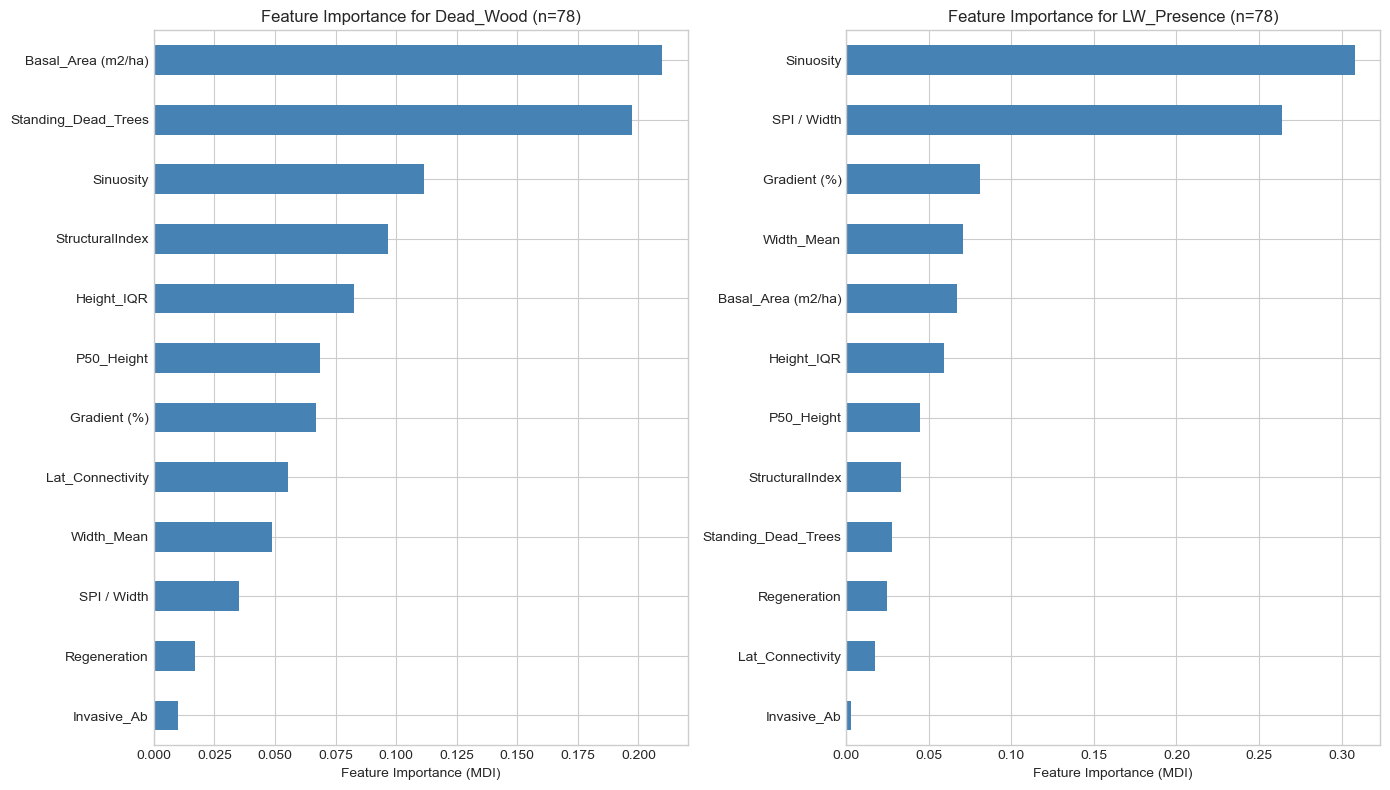

In [ ]:
# Prepare feature matrix
numeric_features = df[FEATURE_COLS].select_dtypes(include=[np.number]).columns.tolist()
# Remove columns that are completely empty
numeric_features = [col for col in numeric_features if df[col].notna().any()]
feature_names = numeric_features

# Results storage
importance_results = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, target in enumerate(TARGET_COLS):
    # Prepare data with proper index alignment
    data_df = df[numeric_features + [target]].dropna()
    
    if len(data_df) == 0:
        print(f"Warning: No valid samples for {target}. Skipping...")
        continue
    
    X_valid = data_df[numeric_features]
    y_valid = data_df[target]
    n_samples = len(X_valid)
    
    print(f"{target}: {n_samples} valid samples")
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_valid, y_valid)
    
    # Get feature importances
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=True)
    importance_results[target] = importances
    
    # Plot
    importances.plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_xlabel('Feature Importance (MDI)')
    axes[idx].set_title(f'Feature Importance for {target} (n={n_samples})')

plt.tight_layout()
plt.show()


In [ ]:
# Compare top important features for both targets
print("Top 5 Important Features Comparison:")
print("="*60)
print(f"{'Rank':<6}{'Dead_Wood':<25}{'LW_Presence':<25}")
print("-"*60)

dw_top = importance_results['Dead_Wood'].nlargest(5)
lw_top = importance_results['LW_Presence'].nlargest(5)

for i in range(5):
    dw_feat = f"{dw_top.index[i]} ({dw_top.iloc[i]:.3f})"
    lw_feat = f"{lw_top.index[i]} ({lw_top.iloc[i]:.3f})"
    print(f"{i+1:<6}{dw_feat:<25}{lw_feat:<25}")

Top 5 Important Features Comparison:
Rank  Dead_Wood                LW_Presence              
------------------------------------------------------------
1     Basal_Area (m2/ha) (0.210)Sinuosity (0.308)        
2     Standing_Dead_Trees (0.197)SPI / Width (0.264)      
3     Sinuosity (0.112)        Gradient (%) (0.081)     
4     StructuralIndex (0.097)  Width_Mean (0.071)       
5     Height_IQR (0.083)       Basal_Area (m2/ha) (0.067)


5-Fold Cross-Validation (GroupKFold by Reach)

Dead_Wood (n=78 samples)
Fold  R² Train    R² Test     MAE       RMSE      
--------------------------------------------------
1     0.9003      -0.1310     0.7231    1.0779    
2     0.8974      0.1448      0.6500    0.8336    
3     0.8961      0.2882      0.6875    0.8014    
4     0.8869      0.0135      0.6525    0.8602    
5     0.8841      0.4177      0.6686    0.7493    

Metric              Train          Test           
--------------------------------------------------
R² Mean             0.8929         0.1466         
R² Std              0.0063         0.1941         
MAE Mean            ---            0.6763         
MAE Std             ---            0.0270         
RMSE Mean           ---            0.8645         
RMSE Std            ---            0.1129         

LW_Presence (n=78 samples)
Fold  R² Train    R² Test     MAE       RMSE      
--------------------------------------------------
1     0.9517      -0.6524     1.

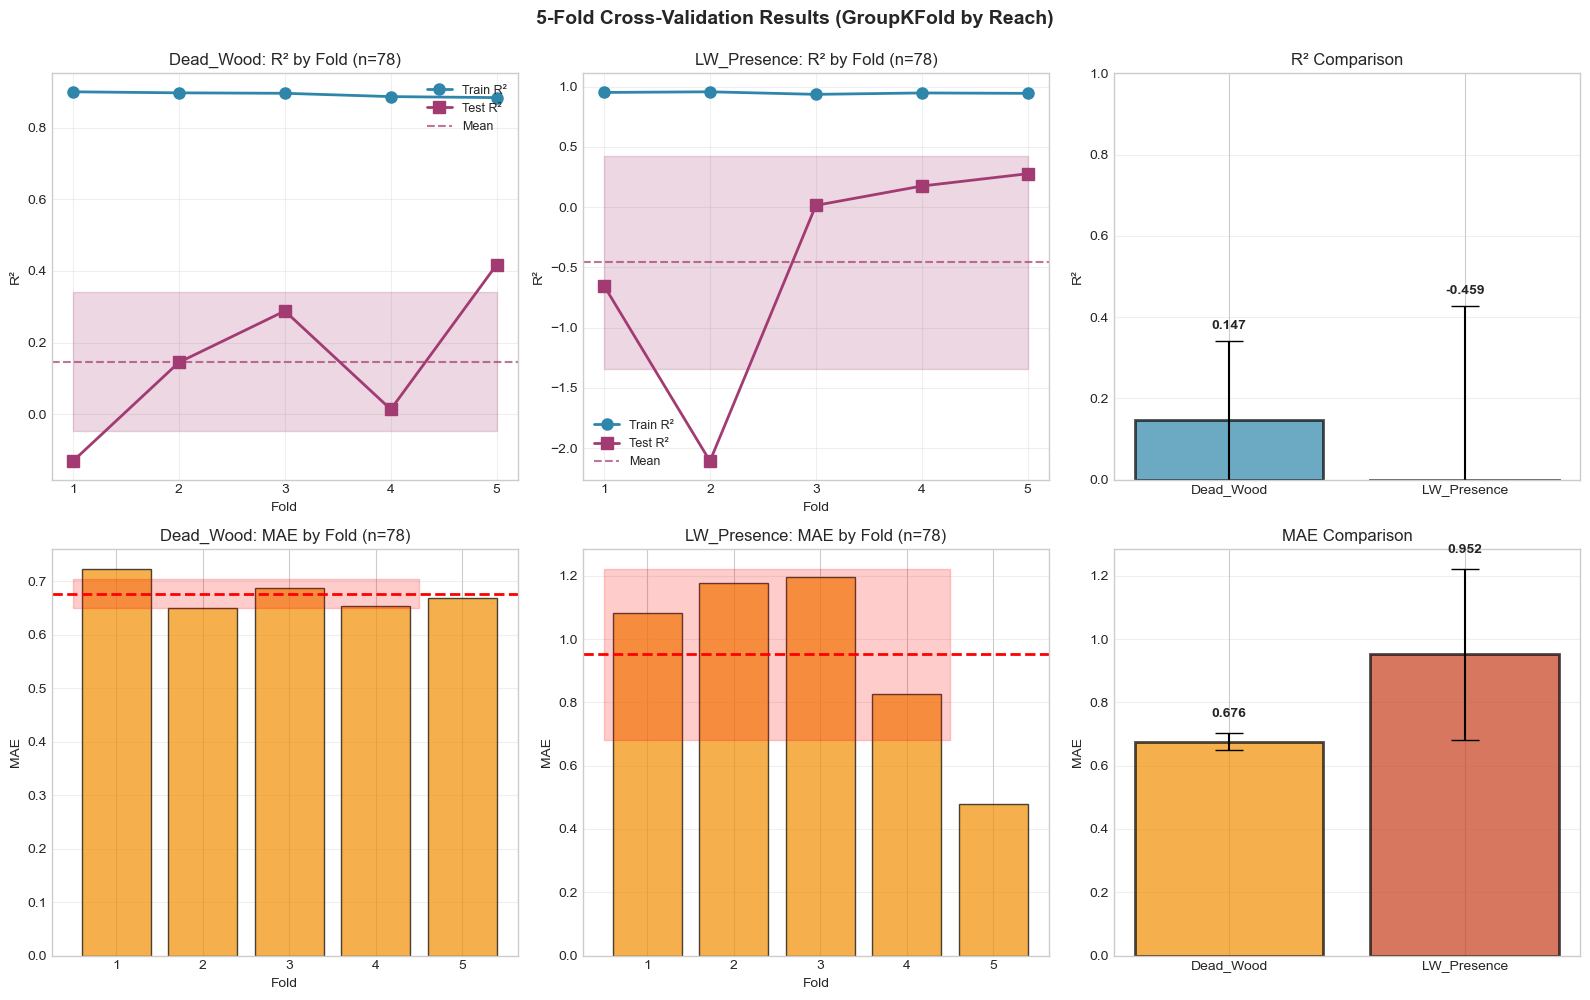

In [ ]:
from sklearn.model_selection import cross_validate, GroupKFold

# Group by Reach to avoid data leakage
data_df_cv = df[numeric_features + TARGET_COLS + ['Reach']].dropna()
groups = pd.factorize(data_df_cv['Reach'])[0]
gkfold = GroupKFold(n_splits=5)

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error'
}

cv_results_all = {}

print("="*80)
print("5-Fold Cross-Validation (GroupKFold by Reach)")
print("="*80)

for target in TARGET_COLS:
    print(f"\n{target} (n={len(data_df_cv)} samples)")
    
    X = data_df_cv[numeric_features]
    y = data_df_cv[target]
    
    # Cross-validation
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    cv_results = cross_validate(rf, X, y, cv=gkfold, groups=groups, 
                                scoring=scoring, return_train_score=True)
    
    # Convert metrics to positive values
    cv_results['mae'] = -cv_results['test_neg_mae']
    cv_results['rmse'] = np.sqrt(-cv_results['test_neg_mse'])
    cv_results['train_mae'] = -cv_results['train_neg_mae']
    cv_results['train_rmse'] = np.sqrt(-cv_results['train_neg_mse'])
    
    cv_results_all[target] = cv_results
    
    # Print results by fold
    print(f"{'Fold':<6}{'R² Train':<12}{'R² Test':<12}{'MAE':<10}{'RMSE':<10}")
    print("-" * 50)
    for i in range(5):
        print(f"{i+1:<6}{cv_results['train_r2'][i]:<12.4f}{cv_results['test_r2'][i]:<12.4f}{cv_results['mae'][i]:<10.4f}{cv_results['rmse'][i]:<10.4f}")
    
    # Summary statistics
    print(f"\n{'Metric':<20}{'Train':<15}{'Test':<15}")
    print("-" * 50)
    print(f"{'R² Mean':<20}{cv_results['train_r2'].mean():<15.4f}{cv_results['test_r2'].mean():<15.4f}")
    print(f"{'R² Std':<20}{cv_results['train_r2'].std():<15.4f}{cv_results['test_r2'].std():<15.4f}")
    print(f"{'MAE Mean':<20}{'---':<15}{cv_results['mae'].mean():<15.4f}")
    print(f"{'MAE Std':<20}{'---':<15}{cv_results['mae'].std():<15.4f}")
    print(f"{'RMSE Mean':<20}{'---':<15}{cv_results['rmse'].mean():<15.4f}")
    print(f"{'RMSE Std':<20}{'---':<15}{cv_results['rmse'].std():<15.4f}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, target in enumerate(TARGET_COLS):
    cv_results = cv_results_all[target]
    folds = np.arange(1, 6)
    
    # R² by fold
    ax = axes[0, idx]
    ax.plot(folds, cv_results['train_r2'], 'o-', linewidth=2, markersize=8, 
            label='Train R²', color='#2E86AB')
    ax.plot(folds, cv_results['test_r2'], 's-', linewidth=2, markersize=8, 
            label='Test R²', color='#A23B72')
    ax.axhline(cv_results['test_r2'].mean(), color='#A23B72', linestyle='--', 
               alpha=0.7, label='Mean')
    ax.fill_between(folds, 
                    cv_results['test_r2'].mean() - cv_results['test_r2'].std(),
                    cv_results['test_r2'].mean() + cv_results['test_r2'].std(),
                    alpha=0.2, color='#A23B72')
    ax.set_xlabel('Fold')
    ax.set_ylabel('R²')
    ax.set_title(f'{target}: R² by Fold (n={len(data_df_cv)})')
    ax.set_xticks(folds)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # MAE by fold
    ax = axes[1, idx]
    ax.bar(folds, cv_results['mae'], alpha=0.7, color='#F18F01', edgecolor='black')
    ax.axhline(cv_results['mae'].mean(), color='red', linestyle='--', linewidth=2)
    ax.fill_between(folds - 0.5, 
                    cv_results['mae'].mean() - cv_results['mae'].std(),
                    cv_results['mae'].mean() + cv_results['mae'].std(),
                    alpha=0.2, color='red')
    ax.set_xlabel('Fold')
    ax.set_ylabel('MAE')
    ax.set_title(f'{target}: MAE by Fold (n={len(data_df_cv)})')
    ax.set_xticks(folds)
    ax.grid(True, alpha=0.3, axis='y')

# Summary comparison
ax = axes[0, 2]
x_pos = np.arange(len(TARGET_COLS))
r2_means = [cv_results_all[t]['test_r2'].mean() for t in TARGET_COLS]
r2_stds = [cv_results_all[t]['test_r2'].std() for t in TARGET_COLS]

bars = ax.bar(x_pos, r2_means, yerr=r2_stds, capsize=10, alpha=0.7, 
              color=['#2E86AB', '#A23B72'], edgecolor='black', linewidth=2)
ax.set_ylabel('R²')
ax.set_title('R² Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(TARGET_COLS)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bar, mean, std in zip(bars, r2_means, r2_stds):
    ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.03, f'{mean:.3f}', 
            ha='center', fontsize=10, fontweight='bold')

# MAE comparison
ax = axes[1, 2]
mae_means = [cv_results_all[t]['mae'].mean() for t in TARGET_COLS]
mae_stds = [cv_results_all[t]['mae'].std() for t in TARGET_COLS]

bars = ax.bar(x_pos, mae_means, yerr=mae_stds, capsize=10, alpha=0.7, 
              color=['#F18F01', '#C73E1D'], edgecolor='black', linewidth=2)
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(TARGET_COLS)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean, std in zip(bars, mae_means, mae_stds):
    ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.05, f'{mean:.3f}', 
            ha='center', fontsize=10, fontweight='bold')

plt.suptitle('5-Fold Cross-Validation Results (GroupKFold by Reach)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Relationship Between Target Variables

This section explores **how our two main variables of interest relate to each other**. Understanding this relationship is important because:
- If they are highly correlated, they may be driven by similar underlying ecological processes
- If they differ by basin, it suggests location-specific factors influence their relationship

**How to read these plots:**
- **Left plot:** Overall scatter of Dead_Wood vs LW_Presence, colored by Basin
- **Right plot:** Same relationship but with **linear regression trend lines** for each Basin
- **r value:** Overall Pearson correlation between the two target variables

The dashed trend lines show whether the relationship direction/strength differs between the Arve and Valserine basins.

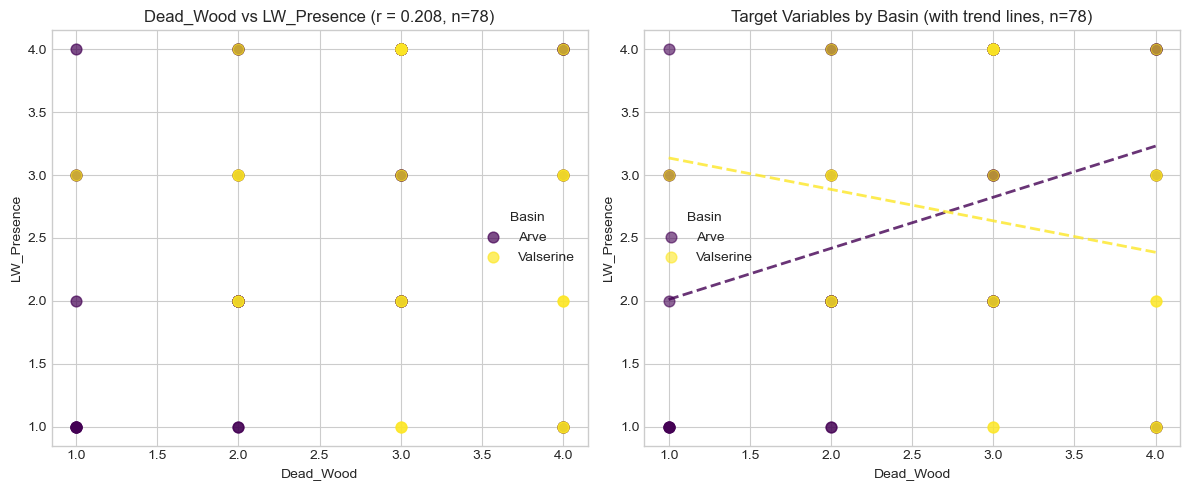


Correlation between Dead_Wood and LW_Presence by Basin:
  Arve: r = 0.353
  Valserine: r = -0.200


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
n_total = len(df.dropna(subset=['Dead_Wood', 'LW_Presence']))

# Color palette for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Left plot: Scatter plot of target variables with proper legend
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[0].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   c=[basin_colors[basin]], alpha=0.7, s=60, label=basin)

axes[0].set_xlabel('Dead_Wood')
axes[0].set_ylabel('LW_Presence')
r = df[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
axes[0].set_title(f'Dead_Wood vs LW_Presence (r = {r:.3f}, n={n_total})')
axes[0].legend(title='Basin', loc='best')

# Right plot: Distribution by Basin with regression lines
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[1].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   alpha=0.6, s=60, label=basin, c=[basin_colors[basin]])
    # Add regression line per basin
    z = np.polyfit(subset['Dead_Wood'].dropna(), 
                   subset.loc[subset['Dead_Wood'].notna(), 'LW_Presence'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['Dead_Wood'].min(), subset['Dead_Wood'].max(), 100)
    axes[1].plot(x_line, p(x_line), '--', alpha=0.8, color=basin_colors[basin], linewidth=2)

axes[1].set_xlabel('Dead_Wood')
axes[1].set_ylabel('LW_Presence')
axes[1].set_title(f'Target Variables by Basin (with trend lines, n={n_total})')
axes[1].legend(title='Basin', loc='best')

plt.tight_layout()
plt.show()

# Print correlation by basin
print("\nCorrelation between Dead_Wood and LW_Presence by Basin:")
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    r_basin = subset[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
    print(f"  {basin}: r = {r_basin:.3f}")

## 8. Summary Statistics by Location

Examining how target variables vary across different Sub-Basins.

In [ ]:
# Summary by Sub_Basin
location_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS + FEATURE_COLS[:5]].agg(['mean', 'std', 'count'])
location_summary = location_summary.round(2)

# Display target variable summary
target_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS].agg(['mean', 'std', 'min', 'max', 'count'])
print("Target Variables by Location:")
print("="*80)
print(target_summary)

Target Variables by Location:
                    Dead_Wood                         LW_Presence            \
                         mean       std min max count        mean       std   
Basin     Sub_Basin                                                           
Arve      Arve       2.382353  1.015477   1   4    34    2.588235  1.047874   
          Giffre     2.750000  0.856349   1   4    16    2.500000  1.264911   
          Menoge     3.000000  0.894427   2   4     6    3.333333  1.032796   
Valserine Semine     2.625000  1.187735   1   4     8    2.500000  1.195229   
          Valserine  3.214286  0.578934   2   4    14    2.714286  1.069045   

                                   
                    min max count  
Basin     Sub_Basin                
Arve      Arve        1   4    34  
          Giffre      1   4    16  
          Menoge      2   4     6  
Valserine Semine      1   4     8  
          Valserine   1   4    14  


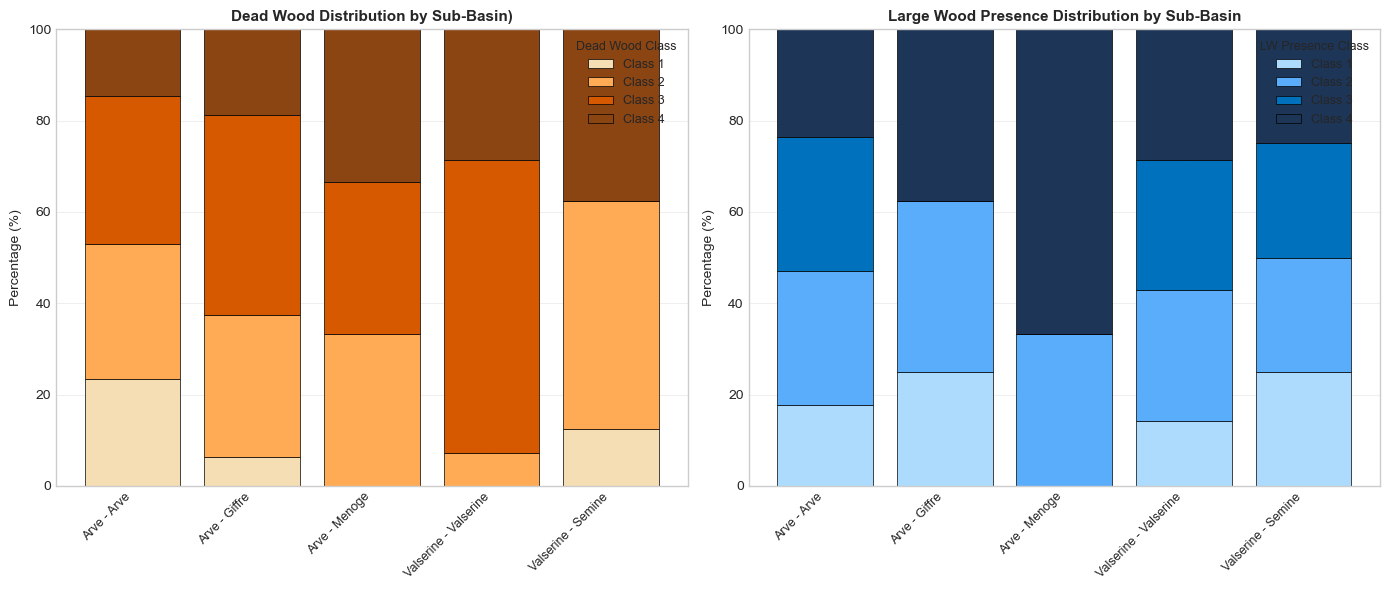

In [ ]:
# Visualization: 100% Stacked Bar Charts by Sub-Basin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df_plot = df.copy()
df_plot['Location'] = df_plot['Basin'] + ' - ' + df_plot['Sub_Basin']

# Define color palette by Sub-Basin
subbasin_colors = {
    'Arve - Arve': '#E63946',
    'Arve - Giffre': '#F77F00',
    'Arve - Menoge': '#FCBF49',
    'Valserine - Valserine': '#1D3557',
    'Valserine - Semine': '#457B9D',
}

# Get unique locations sorted
unique_locations = sorted(df_plot['Location'].unique())
x_pos = np.arange(len(unique_locations))

# ============ DEAD_WOOD PLOT ============
# Create crosstab: rows=Location, columns=Dead_Wood class values (1-4), normalized to 100%
dw_crosstab = pd.crosstab(df_plot['Location'], df_plot['Dead_Wood'])
dw_crosstab = dw_crosstab.sort_index(key=lambda x: x.map({'Arve - Arve': 0, 'Arve - Giffre': 1, 
                                                            'Arve - Menoge': 2, 'Valserine - Valserine': 3, 
                                                            'Valserine - Semine': 4}))

# Sort columns (class values) from 4 down to 1
dw_crosstab = dw_crosstab[[col for col in sorted(dw_crosstab.columns, reverse=True) if col in dw_crosstab.columns]]

# Normalize to percentages (100%)
dw_pct = dw_crosstab.div(dw_crosstab.sum(axis=1), axis=0) * 100

# Create stacked bar chart for Dead_Wood using global color palette
bottom = np.zeros(len(dw_pct))
for col in sorted(dw_pct.columns):  # 1 to 4
    axes[0].bar(range(len(dw_pct)), dw_pct[col], bottom=bottom, 
                label=f'Class {int(col)}', color=dw_class_colors.get(col, '#888888'), 
                edgecolor='black', linewidth=0.5)
    bottom += dw_pct[col].values

axes[0].set_xticks(range(len(dw_pct)))
axes[0].set_xticklabels(dw_pct.index, rotation=45, ha='right', fontsize=9)
axes[0].set_ylabel('Percentage (%)', fontsize=10)
axes[0].set_title('Dead Wood Distribution by Sub-Basin)', fontsize=11, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].legend(loc='upper right', fontsize=9, title='Dead Wood Class', title_fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# ============ LW_PRESENCE PLOT ============
# Create crosstab: rows=Location, columns=LW_Presence class values, normalized to 100%
lw_crosstab = pd.crosstab(df_plot['Location'], df_plot['LW_Presence'])
lw_crosstab = lw_crosstab.sort_index(key=lambda x: x.map({'Arve - Arve': 0, 'Arve - Giffre': 1, 
                                                            'Arve - Menoge': 2, 'Valserine - Valserine': 3, 
                                                            'Valserine - Semine': 4}))

# Sort columns (class values) from 4 down to 1
lw_crosstab = lw_crosstab[[col for col in sorted(lw_crosstab.columns, reverse=True) if col in lw_crosstab.columns]]

# Normalize to percentages (100%)
lw_pct = lw_crosstab.div(lw_crosstab.sum(axis=1), axis=0) * 100

# Create stacked bar chart for LW_Presence using global color palette
bottom = np.zeros(len(lw_pct))
for col in sorted(lw_pct.columns):  # 1 to 4
    axes[1].bar(range(len(lw_pct)), lw_pct[col], bottom=bottom, 
                label=f'Class {int(col)}', color=lw_class_colors.get(col, '#888888'), 
                edgecolor='black', linewidth=0.5)
    bottom += lw_pct[col].values

axes[1].set_xticks(range(len(lw_pct)))
axes[1].set_xticklabels(lw_pct.index, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Percentage (%)', fontsize=10)
axes[1].set_title('Large Wood Presence Distribution by Sub-Basin', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].legend(loc='upper right', fontsize=9, title='LW Presence Class', title_fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Value Ranges Associated with Target Values 1-4

This section identifies which **values and ranges** of the top 8 most important features 
are associated with different target values (1-4).

This is useful for understanding:
- What feature ranges characterize each target category
- Whether there are clear value thresholds that distinguish target classes
- How feature distributions shift across target values

**Visualizations:**
- **Violin plots:** Show full distribution of each feature for each target value
- **Heatmap:** Displays median feature values across target categories
- **Distribution plots:** Highlight how features concentrate at different target levels

In [ ]:
# Get top 8 most important features for EACH target variable separately
top_n = 8

# Get importance scores
dw_importance = importance_results['Dead_Wood'].sort_values(ascending=False)
lw_importance = importance_results['LW_Presence'].sort_values(ascending=False)

# Create separate top 8 lists for each target
top_8_features_dw = dw_importance.head(top_n).index.tolist()
top_8_features_lw = lw_importance.head(top_n).index.tolist()

print(f"Top {top_n} Most Important Features for Dead_Wood:")
print("="*50)
for i, feat in enumerate(top_8_features_dw, 1):
    print(f"{i}. {feat}: {dw_importance[feat]:.4f}")

print(f"\n\nTop {top_n} Most Important Features for LW_Presence:")
print("="*50)
for i, feat in enumerate(top_8_features_lw, 1):
    print(f"{i}. {feat}: {lw_importance[feat]:.4f}")

Top 8 Most Important Features for Dead_Wood:
1. Basal_Area (m2/ha): 0.2097
2. Standing_Dead_Trees: 0.1974
3. Sinuosity: 0.1116
4. StructuralIndex: 0.0966
5. Height_IQR: 0.0825
6. P50_Height: 0.0687
7. Gradient (%): 0.0668
8. Lat_Connectivity: 0.0556


Top 8 Most Important Features for LW_Presence:
1. Sinuosity: 0.3079
2. SPI / Width: 0.2641
3. Gradient (%): 0.0807
4. Width_Mean: 0.0709
5. Basal_Area (m2/ha): 0.0674
6. Height_IQR: 0.0589
7. P50_Height: 0.0445
8. StructuralIndex: 0.0330


In [ ]:
# Prepare data for Dead_Wood analysis
df_dead_wood = df[df['Dead_Wood'].isin([1, 2, 3, 4])].copy()
df_dead_wood['Dead_Wood_Category'] = df_dead_wood['Dead_Wood'].astype(str)

print(f"Dead_Wood data prepared:")
print(f"  Total samples: {len(df_dead_wood)}")
print(f"  Dead_Wood categories: {sorted(df_dead_wood['Dead_Wood'].unique())}")

# Prepare data for LW_Presence analysis
df_lw = df[df['LW_Presence'].isin([1, 2, 3, 4])].copy()
df_lw['LW_Presence_Category'] = df_lw['LW_Presence'].astype(str)

print(f"\nLW_Presence data prepared:")
print(f"  Total samples: {len(df_lw)}")
print(f"  LW_Presence categories: {sorted(df_lw['LW_Presence'].unique())}")

Dead_Wood data prepared:
  Total samples: 78
  Dead_Wood categories: [1, 2, 3, 4]

LW_Presence data prepared:
  Total samples: 78
  LW_Presence categories: [1, 2, 3, 4]


### Dead_Wood Analysis: Distribution of Top Features by Dead_Wood Value (1-4)

In [ ]:
# Summary statistics for Dead_Wood analysis
print("\n" + "="*80)
print("SUMMARY: Feature Statistics by Dead_Wood Value")
print("="*80)

for feat in top_8_features_dw:
    print(f"\n{feat}:")
    print("-" * 60)
    summary = df_dead_wood.groupby('Dead_Wood_Category')[feat].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(2))


SUMMARY: Feature Statistics by Dead_Wood Value

Basal_Area (m2/ha):
------------------------------------------------------------
                    count   mean    std    min    max
Dead_Wood_Category                                   
1                      10  16.18   6.70   6.20  26.15
2                      22  30.96   6.04  20.95  45.95
3                      29  35.81  10.00  15.60  55.15
4                      17  33.91  11.36  13.40  57.91

Standing_Dead_Trees:
------------------------------------------------------------
                    count  mean   std  min  max
Dead_Wood_Category                             
1                      10  1.50  0.53    1    2
2                      22  1.91  0.75    1    3
3                      29  2.83  0.71    1    4
4                      17  2.94  0.75    2    4

Sinuosity:
------------------------------------------------------------
                    count  mean   std   min   max
Dead_Wood_Category                               
1 

In [ ]:
# Helper function to format p-values for publication-quality output
def format_pvalue(p):
    """
    Format p-value based on magnitude:
    - p < 0.001 → "p < 0.001"
    - 0.001 ≤ p < 0.01 → 3 decimals (e.g., "p = 0.005")
    - 0.01 ≤ p < 0.1 → 3 decimals (e.g., "p = 0.058")
    - p ≥ 0.1 → 2 decimals (e.g., "p = 0.12")
    """
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    elif p < 0.1:
        return f"p = {p:.3f}"
    else:
        return f"p = {p:.2f}"


In [ ]:
# Statistical tests for Dead_Wood: Kruskal-Wallis and Spearman correlation
from scipy.stats import kruskal, spearmanr

print('\n' + '='*100)
print('STATISTICAL TESTS FOR DEAD_WOOD - Top 8 Features')
print('='*100)
print(f'\nKruskal-Wallis (H-test) - Tests if distributions differ across Dead_Wood Classes (1-4)')
print(f'Spearman rho - Correlation with Dead_Wood ordinal variable (1-4)')
print('\n' + '-'*100)
print(f'{"Feature":<30} {"Kruskal-Wallis H":<20} {"p-value (KW)":<18} {"Spearman rho":<18} {"p-value (Spearman)":<18}')
print('-'*100)

stats_dw = []

for feat in top_8_features_dw:
    # Prepare data
    feat_data = df_dead_wood[[feat, 'Dead_Wood_Category']].dropna()
    
    if len(feat_data) > 0:
        # Kruskal-Wallis test
        groups = [feat_data[feat_data['Dead_Wood_Category'] == str(i)][feat].values 
                  for i in [1, 2, 3, 4]]
        groups = [g for g in groups if len(g) > 0]  # Remove empty groups
        
        if len(groups) > 1:
            h_stat, kw_pvalue = kruskal(*groups)
        else:
            h_stat, kw_pvalue = np.nan, np.nan
        
        # Spearman correlation with ordinal Dead_Wood
        dead_wood_numeric = feat_data['Dead_Wood_Category'].astype(int)
        rho, spear_pvalue = spearmanr(feat_data[feat], dead_wood_numeric)
        
        stats_dw.append({
            'Feature': feat,
            'Kruskal-Wallis H': h_stat,
            'KW p-value': kw_pvalue,
            'Spearman rho': rho,
            'Spearman p-value': spear_pvalue
        })
        
        print(f'{feat:<30} {h_stat:<20.4f} {kw_pvalue:<18.4e} {rho:<18.4f} {spear_pvalue:<18.4e}')

# Create DataFrame for better visualization
stats_dw_df = pd.DataFrame(stats_dw)
print('\n' + '='*100)
print('Summary Table:')
print(stats_dw_df.to_string(index=False))


STATISTICAL TESTS FOR DEAD_WOOD - Top 8 Features

Kruskal-Wallis (H-test) - Tests if distributions differ across Dead_Wood Classes (1-4)
Spearman rho - Correlation with Dead_Wood ordinal variable (1-4)

----------------------------------------------------------------------------------------------------
Feature                        Kruskal-Wallis H     p-value (KW)       Spearman rho       p-value (Spearman)
----------------------------------------------------------------------------------------------------
Basal_Area (m2/ha)             22.5826              4.9338e-05         0.4053             2.3256e-04        
Standing_Dead_Trees            30.1264              1.2981e-06         0.5873             1.5890e-08        
Sinuosity                      7.4609               5.8572e-02         0.3044             6.7374e-03        
StructuralIndex                12.8257              5.0290e-03         0.3799             6.0286e-04        
Height_IQR                     12.3090           

c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigni

c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigni

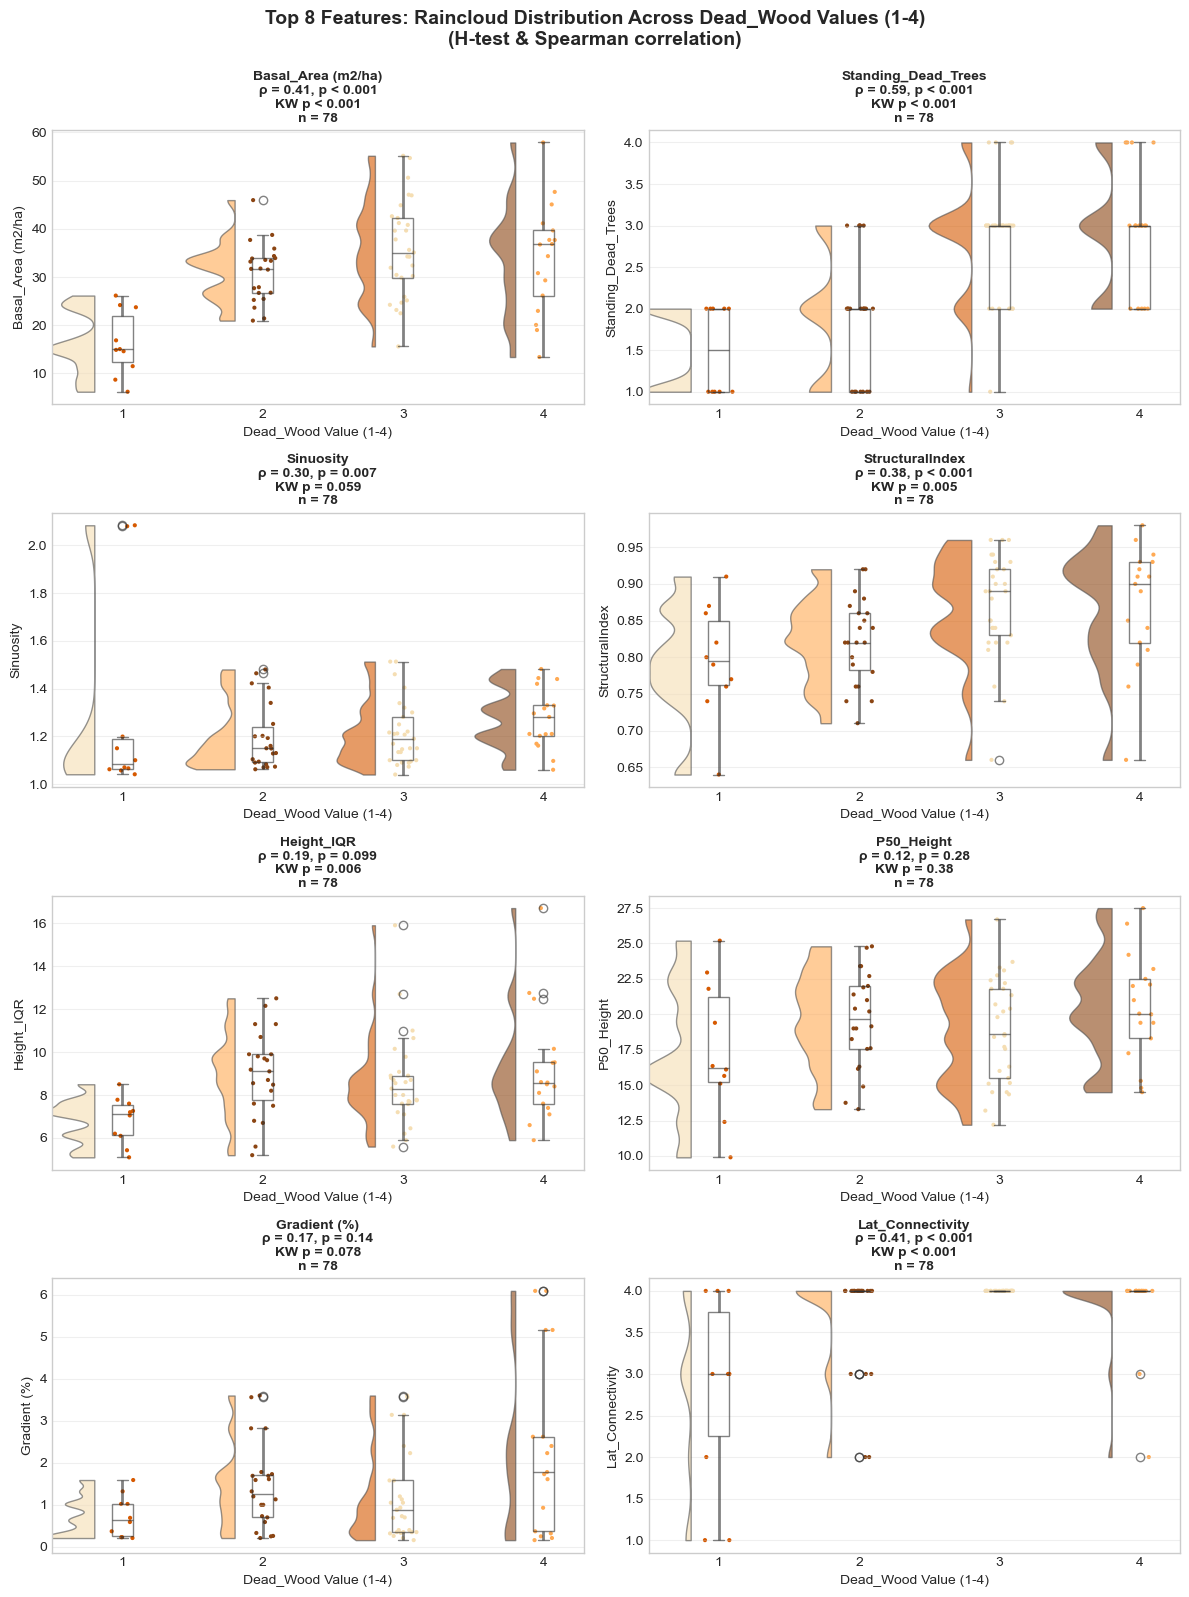

In [ ]:
# Install ptitprince for raincloud plots if needed
try:
    import ptitprince as pt
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ptitprince", "-q"])
    import ptitprince as pt

# Raincloud plots for Dead_Wood - Shows distribution + individual points WITH statistical tests
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_dw):
    # Remove NaN values for this feature
    plot_data = df_dead_wood[[feat, 'Dead_Wood_Category']].dropna()
    n_samples = len(plot_data)
    
    if len(plot_data) > 0:
        pt.RainCloud(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i], 
                     palette=dw_palette_list, order=['1', '2', '3', '4'], alpha=0.6)
        axes[i].set_xlabel('Dead_Wood Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_dw_df[stats_dw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}\nn = {n_samples}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Raincloud Distribution Across Dead_Wood Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\1152030874.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\1152030874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\1152030874.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\1152030874.py:12: FutureWar

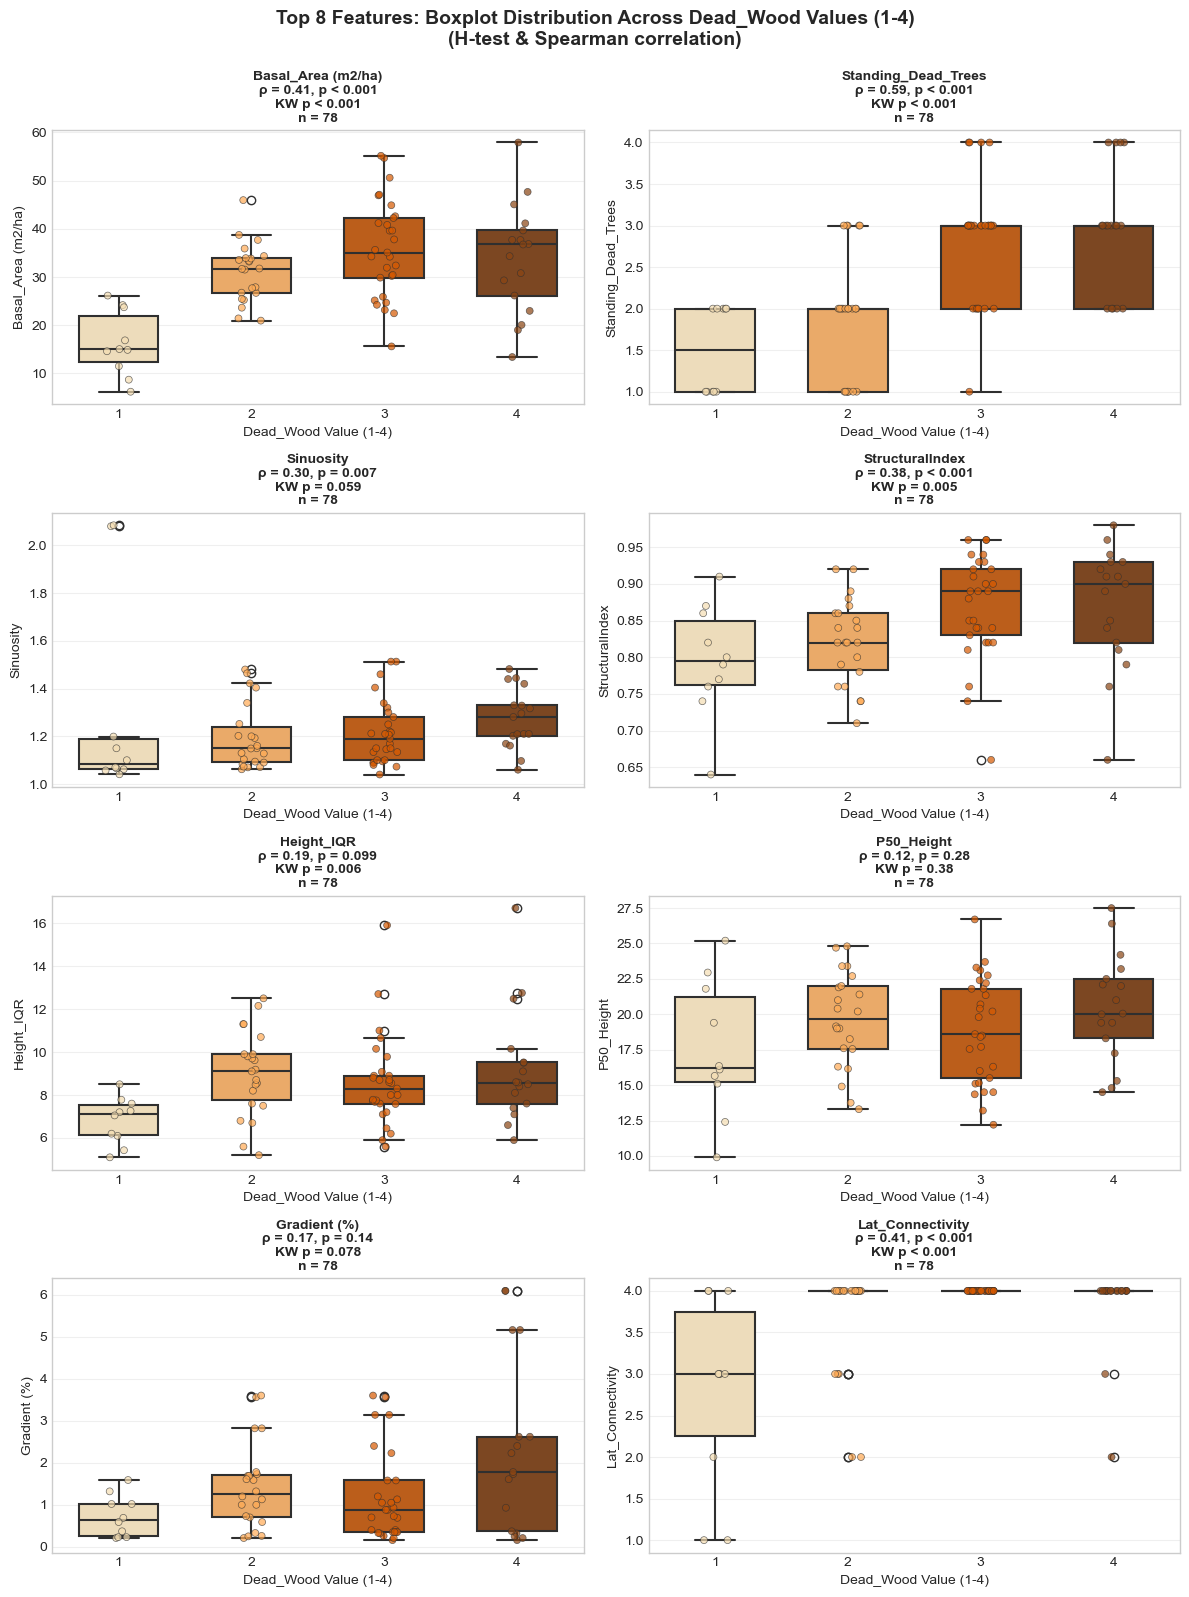

In [ ]:
# Boxplots with individual points for Dead_Wood - Simplified view
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_dw):
    # Remove NaN values for this feature
    plot_data = df_dead_wood[[feat, 'Dead_Wood_Category']].dropna()
    n_samples = len(plot_data)
    
    if len(plot_data) > 0:
        # Create boxplot
        sns.boxplot(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i],
                   palette=dw_palette_list, order=['1', '2', '3', '4'], width=0.6, 
                   linewidth=1.5, patch_artist=True)
        
        # Overlay individual points
        sns.stripplot(data=plot_data, x='Dead_Wood_Category', y=feat, ax=axes[i],
                     order=['1', '2', '3', '4'], size=5, alpha=0.7, palette=dw_palette_list,
                     jitter=True, edgecolor='gray', linewidth=0.5)
        
        axes[i].set_xlabel('Dead_Wood Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_dw_df[stats_dw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}\nn = {n_samples}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Boxplot Distribution Across Dead_Wood Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Large Wood Presence Analysis: Distribution of Top Features by LW_Presence Value (1-4)

In [ ]:
# Summary statistics for LW_Presence analysis
print("\n" + "="*80)
print("SUMMARY: Feature Statistics by LW_Presence Value")
print("="*80)

for feat in top_8_features_lw:
    print(f"\n{feat}:")
    print("-" * 60)
    summary = df_lw.groupby('LW_Presence_Category')[feat].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(2))


SUMMARY: Feature Statistics by LW_Presence Value

Sinuosity:
------------------------------------------------------------
                      count  mean   std   min   max
LW_Presence_Category                               
1                        14  1.15  0.10  1.06  1.33
2                        24  1.16  0.12  1.06  1.46
3                        16  1.34  0.30  1.13  2.08
4                        24  1.27  0.16  1.04  1.51

SPI / Width:
------------------------------------------------------------
                      count   mean    std  min   max
LW_Presence_Category                                
1                        14  18.08  14.87  3.2  38.9
2                        24  14.70  13.01  1.3  45.6
3                        16   5.01   4.07  1.7  12.0
4                        24   6.34   5.27  0.9  18.4

Gradient (%):
------------------------------------------------------------
                      count  mean   std   min   max
LW_Presence_Category                        

In [ ]:
# Statistical tests for LW_Presence: Kruskal-Wallis and Spearman correlation
print('\n' + '='*100)
print('STATISTICAL TESTS FOR LW_PRESENCE - Top 8 Features')
print('='*100)
print(f'\nKruskal-Wallis (H-test) - Tests if distributions differ across LW_Presence Classes (1-4)')
print(f'Spearman rho - Correlation with LW_Presence ordinal variable (1-4)')
print('\n' + '-'*100)
print(f'{"Feature":<30} {"Kruskal-Wallis H":<20} {"p-value (KW)":<18} {"Spearman rho":<18} {"p-value (Spearman)":<18}')
print('-'*100)

stats_lw = []

for feat in top_8_features_lw:
    # Prepare data
    feat_data = df_lw[[feat, 'LW_Presence_Category']].dropna()
    
    if len(feat_data) > 0:
        # Kruskal-Wallis test
        groups = [feat_data[feat_data['LW_Presence_Category'] == str(i)][feat].values 
                  for i in [1, 2, 3, 4]]
        groups = [g for g in groups if len(g) > 0]  # Remove empty groups
        
        if len(groups) > 1:
            h_stat, kw_pvalue = kruskal(*groups)
        else:
            h_stat, kw_pvalue = np.nan, np.nan
        
        # Spearman correlation with ordinal LW_Presence
        lw_numeric = feat_data['LW_Presence_Category'].astype(int)
        rho, spear_pvalue = spearmanr(feat_data[feat], lw_numeric)
        
        stats_lw.append({
            'Feature': feat,
            'Kruskal-Wallis H': h_stat,
            'KW p-value': kw_pvalue,
            'Spearman rho': rho,
            'Spearman p-value': spear_pvalue
        })
        
        print(f'{feat:<30} {h_stat:<20.4f} {kw_pvalue:<18.4e} {rho:<18.4f} {spear_pvalue:<18.4e}')

# Create DataFrame for better visualization
stats_lw_df = pd.DataFrame(stats_lw)
print('\n' + '='*100)
print('Summary Table:')
print(stats_lw_df.to_string(index=False))


STATISTICAL TESTS FOR LW_PRESENCE - Top 8 Features

Kruskal-Wallis (H-test) - Tests if distributions differ across LW_Presence Classes (1-4)
Spearman rho - Correlation with LW_Presence ordinal variable (1-4)

----------------------------------------------------------------------------------------------------
Feature                        Kruskal-Wallis H     p-value (KW)       Spearman rho       p-value (Spearman)
----------------------------------------------------------------------------------------------------
Sinuosity                      13.6490              3.4240e-03         0.3725             7.8332e-04        
SPI / Width                    15.2600              1.6074e-03         -0.3871            4.6404e-04        
Gradient (%)                   17.2035              6.4179e-04         -0.3844            5.1075e-04        
Width_Mean                     7.4377               5.9181e-02         0.2890             1.0293e-02        
Basal_Area (m2/ha)             4.2571      

c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\jdelhoyo\anaconda3\envs\woodrf\lib\site-packages\ptitprince\PtitPrince.py:1070: FutureWarning: 

Passing `palette` without assigni

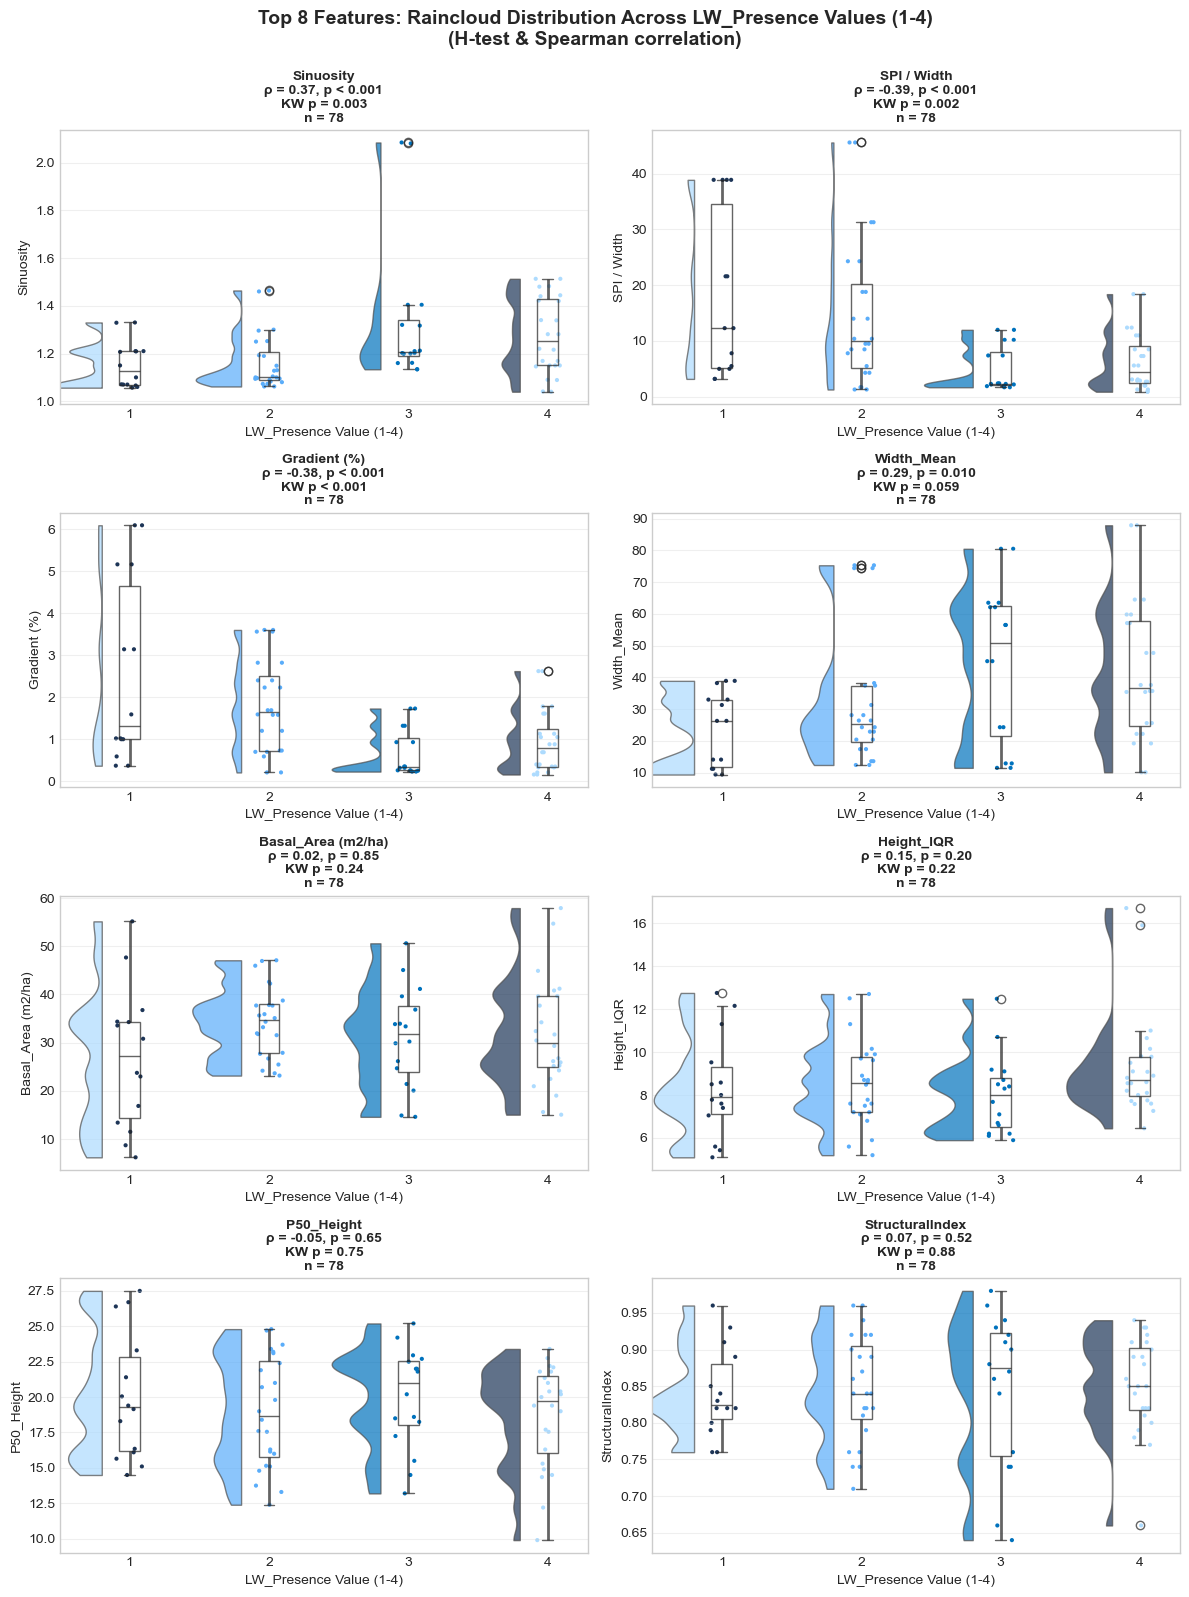

In [ ]:
# Raincloud plots for LW_Presence - Shows distribution + individual points WITH statistical tests
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_lw):
    # Remove NaN values for this feature
    plot_data = df_lw[[feat, 'LW_Presence_Category']].dropna()
    n_samples = len(plot_data)
    
    if len(plot_data) > 0:
        pt.RainCloud(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i], 
                     palette=lw_palette_list, order=['1', '2', '3', '4'], alpha=0.7)
        axes[i].set_xlabel('LW_Presence Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_lw_df[stats_lw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}\nn = {n_samples}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Raincloud Distribution Across LW_Presence Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\3634003594.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\3634003594.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\3634003594.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i],
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_972\3634003594.py:12: Fut

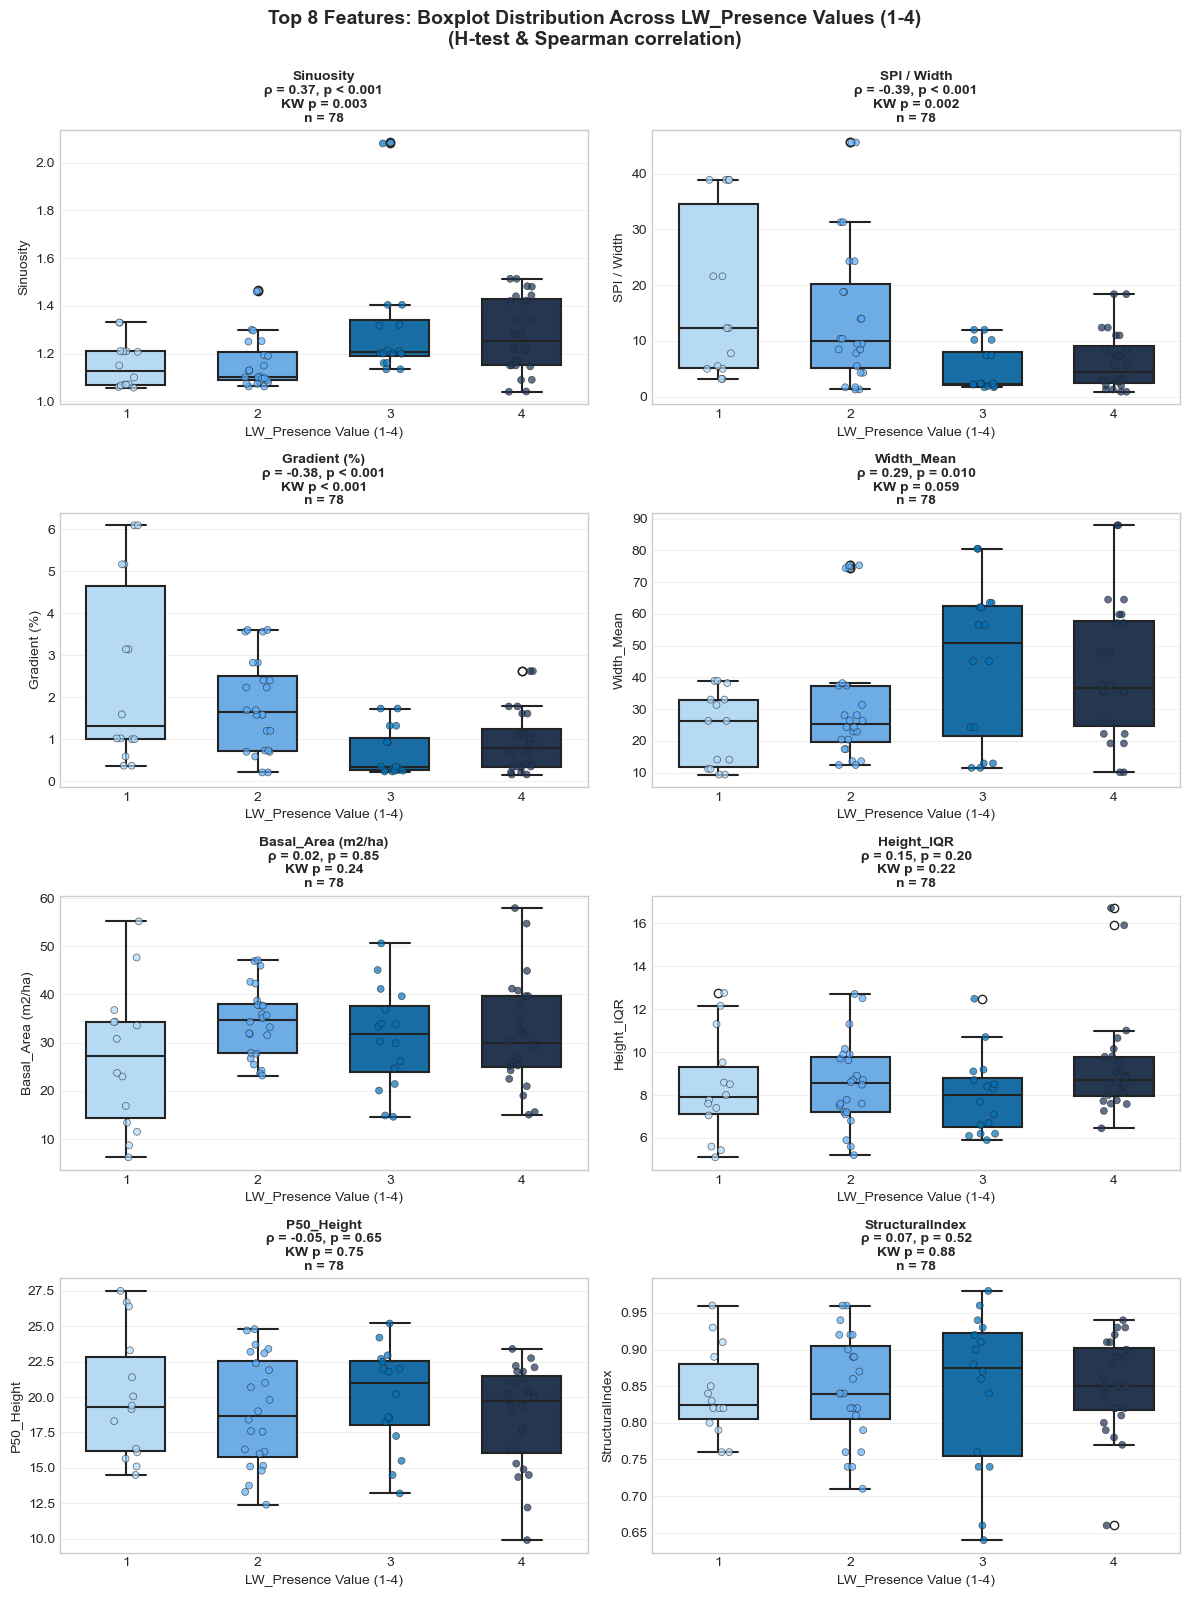

In [ ]:
# Boxplots with individual points for LW_Presence - Simplified view
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

for i, feat in enumerate(top_8_features_lw):
    # Remove NaN values for this feature
    plot_data = df_lw[[feat, 'LW_Presence_Category']].dropna()
    n_samples = len(plot_data)
    
    if len(plot_data) > 0:
        # Create boxplot
        sns.boxplot(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i],
                   palette=lw_palette_list, order=['1', '2', '3', '4'], width=0.6,
                   linewidth=1.5, patch_artist=True)
        
        # Overlay individual points
        sns.stripplot(data=plot_data, x='LW_Presence_Category', y=feat, ax=axes[i],
                     order=['1', '2', '3', '4'], size=5, alpha=0.7,  palette=lw_palette_list,
                      jitter=True, edgecolor='gray', linewidth=0.5)
        
        axes[i].set_xlabel('LW_Presence Value (1-4)', fontsize=10)
        axes[i].set_ylabel(feat, fontsize=10)
        
        # Get statistical test results for this feature
        feat_stats = stats_lw_df[stats_lw_df['Feature'] == feat].iloc[0]
        kw_p = feat_stats['KW p-value']
        rho = feat_stats['Spearman rho']
        spear_p = feat_stats['Spearman p-value']
        
        # Set title with statistical results
        title_text = f'{feat}\nρ = {rho:.2f}, {format_pvalue(spear_p)}\nKW {format_pvalue(kw_p)}\nn = {n_samples}'
        axes[i].set_title(title_text, fontsize=10, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Top 8 Features: Boxplot Distribution Across LW_Presence Values (1-4)\n(H-test & Spearman correlation)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr, kendalltau, chi2_contingency

# Prepare data: samples with both variables present
both_vars = df[(df['Dead_Wood'].isin([1,2,3,4])) & (df['LW_Presence'].isin([1,2,3,4]))].copy()
both_vars['DW_numeric'] = both_vars['Dead_Wood'].astype(int)
both_vars['LW_numeric'] = both_vars['LW_Presence'].astype(int)

print("\n" + "="*100)
print("RELATIONSHIP ANALYSIS: Dead_Wood vs. Large Wood Presence")
print("="*100)
print(f"\nSample size (with both variables): n = {len(both_vars)} riparian units")

# 1. SPEARMAN CORRELATION
spear_rho, spear_p = spearmanr(both_vars['DW_numeric'], both_vars['LW_numeric'])

print("\n" + "-"*100)
print("1. SPEARMAN RANK CORRELATION")
print("-"*100)
print(f"Spearman's rho: {spear_rho:.4f}")
print(f"P-value: {format_pvalue(spear_p)}")
if abs(spear_rho) < 0.3:
    strength = "weak"
elif abs(spear_rho) < 0.7:
    strength = "moderate"
else:
    strength = "strong"
direction = "positive" if spear_rho > 0 else "negative"
print(f"Interpretation: {strength.capitalize()} {direction} monotonic relationship")
print("  - Values closer to +1 or -1 indicate stronger association")
print("  - Values closer to 0 indicate independence")

# 2. KENDALL TAU
tau, tau_p = kendalltau(both_vars['DW_numeric'], both_vars['LW_numeric'])

print("\n" + "-"*100)
print("2. KENDALL'S TAU-B (Alternative Rank Correlation)")
print("-"*100)
print(f"Kendall's tau: {tau:.4f}")
print(f"P-value: {format_pvalue(tau_p)}")
print("  - Tau represents probability of concordant pairs minus discordant pairs")
print("  - More robust to tied values than Spearman")

# 3. CONTINGENCY TABLE & CHI-SQUARE TEST
contingency_table = pd.crosstab(both_vars['Dead_Wood_Category'], 
                                 both_vars['LW_Presence_Category'],
                                 margins=True)

print("\n" + "-"*100)
print("3. CONTINGENCY TABLE: Dead_Wood (rows) vs. LW_Presence (columns)")
print("-"*100)
print(contingency_table)

# Chi-square test (without margins)
ct_no_margins = pd.crosstab(both_vars['Dead_Wood_Category'], 
                             both_vars['LW_Presence_Category'])
chi2, p_chi2, dof, expected = chi2_contingency(ct_no_margins)

print("\n" + "-"*100)
print("4. CHI-SQUARE TEST OF INDEPENDENCE")
print("-"*100)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {format_pvalue(p_chi2)}")
if p_chi2 < 0.05:
    print("Result: SIGNIFICANT association (p < 0.05) - variables are NOT independent")
else:
    print("Result: NO significant association (p ≥ 0.05) - variables appear independent")

# Cramér's V (effect size)
n = len(both_vars)
min_dim = min(ct_no_margins.shape[0] - 1, ct_no_margins.shape[1] - 1)
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

print(f"\nCramér's V (effect size): {cramers_v:.4f}")
if cramers_v < 0.1:
    v_strength = "negligible"
elif cramers_v < 0.3:
    v_strength = "small"
elif cramers_v < 0.5:
    v_strength = "medium"
else:
    v_strength = "large"
print(f"Effect size interpretation: {v_strength.upper()}")

# SUMMARY
print("\n" + "="*100)
print("SUMMARY OF DEAD_WOOD ↔ LW_PRESENCE ASSOCIATION")
print("="*100)
print(f"\nSpearman rho = {spear_rho:.4f}, p = {spear_p:.4e} → {strength.capitalize()} {direction} rank correlation")
print(f"Kendall tau = {tau:.4f}, p = {tau_p:.4e}")
print(f"Chi-square = {chi2:.4f}, p = {p_chi2:.4e}, Cramér's V = {cramers_v:.4f} ({v_strength})")

conclusion = "suggest association" if (spear_p < 0.05 or p_chi2 < 0.05) else "do NOT provide evidence of association"
print(f"\n→ Results {conclusion} between Dead_Wood and Large Wood Presence categories")

# 5. VISUALIZATION: Scatter plot with jitter
fig, ax = plt.subplots(figsize=(10, 7))

# Add jitter to see overlapping points
jitter_strength = 0.08
dw_jitter = both_vars['DW_numeric'] + np.random.normal(0, jitter_strength, len(both_vars))
lw_jitter = both_vars['LW_numeric'] + np.random.normal(0, jitter_strength, len(both_vars))

# Create scatter plot colored by count
scatter = ax.scatter(dw_jitter, lw_jitter, alpha=0.5, s=80, c=range(len(both_vars)), 
                     cmap='viridis', edgecolors='black', linewidth=0.5)

# Add diagonal reference line to show positive correlation trend
ax.plot([0.5, 4.5], [0.5, 4.5], 'r--', linewidth=2, alpha=0.4, label='Perfect positive correlation')

# Formatting
ax.set_xlabel('Dead_Wood Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Large Wood Presence Value', fontsize=12, fontweight='bold')
ax.set_title(f'Relationship: Dead_Wood vs. LW_Presence (n={len(both_vars)})\n(Spearman ρ = {spear_rho:.3f}, p = {spear_p:.4f})',
             fontsize=13, fontweight='bold')
ax.set_xticks([1, 2, 3, 4])
ax.set_yticks([1, 2, 3, 4])
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10)

# Add text box with statistics
textstr = f'Sample: n={len(both_vars)}\nSpearman ρ={spear_rho:.4f}\nKendall τ={tau:.4f}\nCramér V={cramers_v:.4f}'
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


RELATIONSHIP ANALYSIS: Dead_Wood vs. Large Wood Presence

Sample size (with both variables): n = 78 riparian units

----------------------------------------------------------------------------------------------------
1. SPEARMAN RANK CORRELATION
----------------------------------------------------------------------------------------------------
Spearman's rho: 0.2039
P-value: p = 0.073
Interpretation: Weak positive monotonic relationship
  - Values closer to +1 or -1 indicate stronger association
  - Values closer to 0 indicate independence

----------------------------------------------------------------------------------------------------
2. KENDALL'S TAU-B (Alternative Rank Correlation)
----------------------------------------------------------------------------------------------------
Kendall's tau: 0.1794
P-value: p = 0.062
  - Tau represents probability of concordant pairs minus discordant pairs
  - More robust to tied values than Spearman


KeyError: 'Dead_Wood_Category'

## Analysis: Relationship Between Dead_Wood and Large Wood Presence

### Context & Rationale
This section examines the **statistical association between two ordinal forest structure variables**:
- **Dead_Wood (ordinal 1-4):** Level of standing dead trees in riparian forest
- **LW_Presence (ordinal 1-4):** Presence of large wood in the stream

**Why this analysis matters:**
- Both variables are **ordinal** (ordered categories, not numeric), requiring rank-based statistics
- Understanding their relationship reveals whether dead wood and large wood co-occur
- Strong association would suggest that forest structure mechanisms affecting dead wood also influence large wood presence
- Weak/no association would suggest independent ecological processes

**Statistical methods used:**
1. **Spearman's rho:** Rank correlation coefficient for monotonic relationships between ordinal variables
2. **Kendall's tau:** Alternative rank correlation (more interpretable as probability difference)
3. **Chi-square test:** Tests independence in contingency table (nominal association test)
4. **Cramér's V:** Effect size for chi-square (association strength)

### Heatmap: Median Feature Values by Target Category

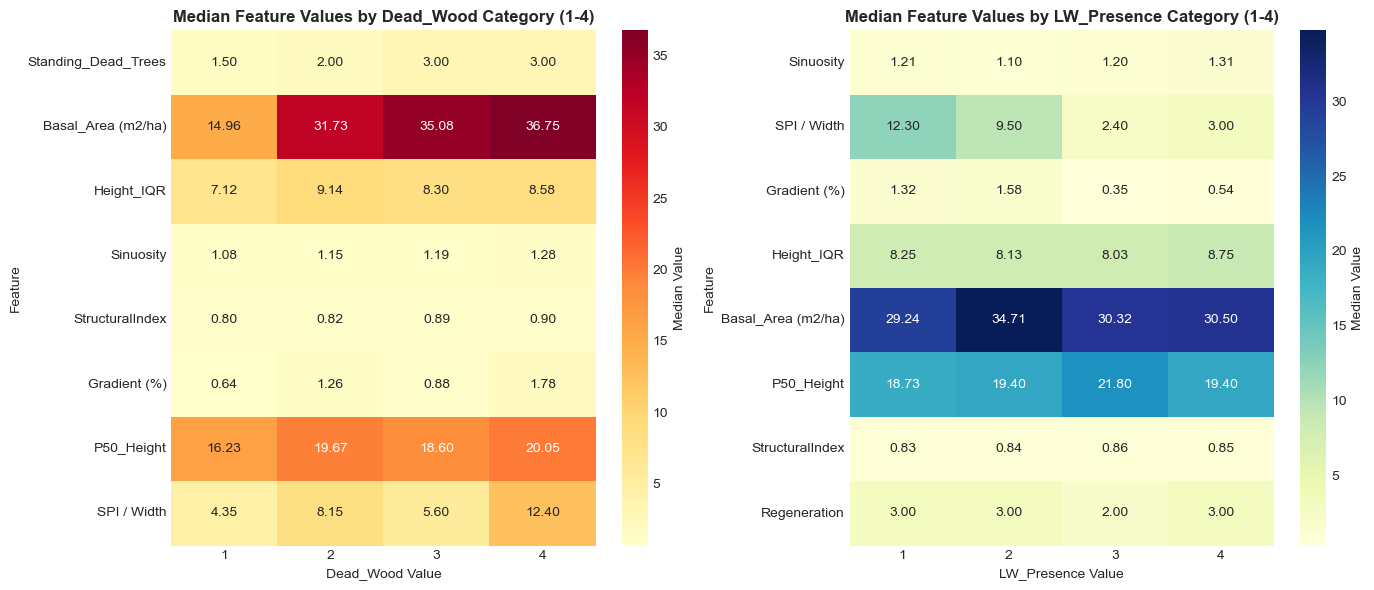

In [ ]:
# Create heatmaps showing median values for better comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
n_dw = len(df_dead_wood)
n_lw = len(df_lw)

# Dead_Wood heatmap
dead_wood_medians = df_dead_wood.groupby('Dead_Wood_Category')[top_8_features_dw].median()
sns.heatmap(dead_wood_medians.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            ax=axes[0], cbar_kws={'label': 'Median Value'})
axes[0].set_title(f'Median Feature Values by Dead_Wood Category (1-4) (n={n_dw})', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Dead_Wood Value')
axes[0].set_ylabel('Feature')

# LW_Presence heatmap
lw_medians = df_lw.groupby('LW_Presence_Category')[top_8_features_lw].median()
sns.heatmap(lw_medians.T, annot=True, fmt='.2f', cmap='YlGnBu', 
            ax=axes[1], cbar_kws={'label': 'Median Value'})
axes[1].set_title(f'Median Feature Values by LW_Presence Category (1-4) (n={n_lw})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('LW_Presence Value')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

### Interpretation: Key Ranges and Thresholds

In [ ]:
print("\n" + "="*80)
print("INTERPRETATION: Feature Value Ranges Associated with Target Categories")
print("="*80)

print("\n--- DEAD WOOD ANALYSIS ---")
for target_val in [1, 2, 3, 4]:
    print(f"\nDead_Wood = {target_val}:")
    subset = df_dead_wood[df_dead_wood['Dead_Wood_Category'] == str(target_val)]
    print(f"  Sample size: {len(subset)}")
    for feat in top_8_features_dw:
        feat_data = subset[feat].dropna()
        if len(feat_data) > 0:
            print(f"  {feat}: [{feat_data.min():.2f} - {feat_data.max():.2f}] (mean: {feat_data.mean():.2f})")

print("\n--- LARGE WOOD PRESENCE ANALYSIS ---")
for target_val in [1, 2, 3, 4]:
    print(f"\nLW_Presence = {target_val}:")
    subset = df_lw[df_lw['LW_Presence_Category'] == str(target_val)]
    print(f"  Sample size: {len(subset)}")
    for feat in top_8_features_lw:
        feat_data = subset[feat].dropna()
        if len(feat_data) > 0:
            print(f"  {feat}: [{feat_data.min():.2f} - {feat_data.max():.2f}] (mean: {feat_data.mean():.2f})")


INTERPRETATION: Feature Value Ranges Associated with Target Categories

--- DEAD WOOD ANALYSIS ---

Dead_Wood = 1:
  Sample size: 10
  Standing_Dead_Trees: [1.00 - 2.00] (mean: 1.50)
  Basal_Area (m2/ha): [6.20 - 26.15] (mean: 16.18)
  Height_IQR: [5.10 - 8.50] (mean: 6.82)
  Sinuosity: [1.04 - 2.08] (mean: 1.29)
  StructuralIndex: [0.64 - 0.91] (mean: 0.80)
  Gradient (%): [0.21 - 1.59] (mean: 0.73)
  P50_Height: [9.90 - 25.20] (mean: 17.48)
  SPI / Width: [1.30 - 12.30] (mean: 6.13)

Dead_Wood = 2:
  Sample size: 22
  Standing_Dead_Trees: [1.00 - 3.00] (mean: 1.91)
  Basal_Area (m2/ha): [20.95 - 45.95] (mean: 30.96)
  Height_IQR: [5.20 - 12.50] (mean: 9.02)
  Sinuosity: [1.06 - 1.48] (mean: 1.20)
  StructuralIndex: [0.71 - 0.92] (mean: 0.82)
  Gradient (%): [0.21 - 3.60] (mean: 1.44)
  P50_Height: [13.30 - 24.80] (mean: 19.58)
  SPI / Width: [1.30 - 45.60] (mean: 11.14)

Dead_Wood = 3:
  Sample size: 29
  Standing_Dead_Trees: [2.00 - 4.00] (mean: 2.86)
  Basal_Area (m2/ha): [15.60 -

## 10. Feature Combinations: Multi-Variable Interactions

This section explores **combinations of variables** and how different feature ranges work together to produce target values.

**Key Questions:**
- Which **combinations** of features best characterize each target value?
- Are there synergistic effects where two features together are more predictive than either alone?
- What feature "profiles" distinguish target categories?

**Visualizations:**
- **Parallel Coordinates:** Show how multiple features combine and flow to each target value
- **2D Heatmaps:** Show joint distributions of pairs of top features and their relationship to targets
- **Pairwise Scatter:** All top feature pairs colored by target value to see joint patterns
- **3D Scatter:** Show 3-way feature combinations and target relationships

Features used for parallel coordinates:
  Dead_Wood: ['Basal_Area (m2/ha)', 'Standing_Dead_Trees', 'Sinuosity', 'StructuralIndex', 'Height_IQR', 'P50_Height', 'Gradient (%)', 'Lat_Connectivity']
  LW_Presence: ['Sinuosity', 'SPI / Width', 'Gradient (%)', 'Width_Mean', 'Basal_Area (m2/ha)', 'Height_IQR', 'P50_Height', 'StructuralIndex']



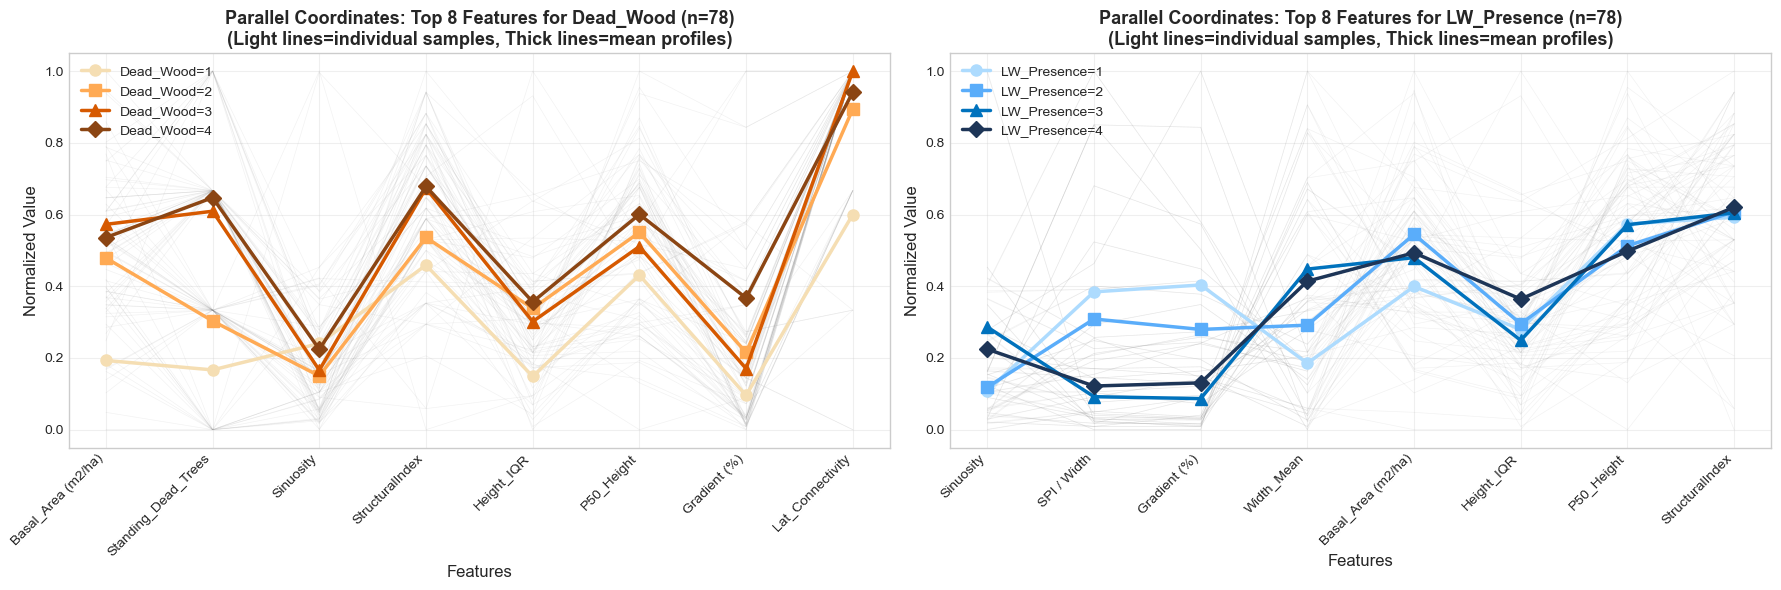


Parallel Coordinates Notes:
- Each line represents one sample
- Thick lines show mean values for each category
- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)
- Dead_Wood using top 8 features: ['Basal_Area (m2/ha)', 'Standing_Dead_Trees', 'Sinuosity', 'StructuralIndex', 'Height_IQR', 'P50_Height', 'Gradient (%)', 'Lat_Connectivity']
- LW_Presence using top 8 features: ['Sinuosity', 'SPI / Width', 'Gradient (%)', 'Width_Mean', 'Basal_Area (m2/ha)', 'Height_IQR', 'P50_Height', 'StructuralIndex']
- Shows how features vary together across the target variable categories


In [ ]:
# Parallel Coordinates Plot - Dead_Wood and LW_Presence
# Import MinMaxScaler (needed for normalization)
from sklearn.preprocessing import MinMaxScaler

# Select top 8 features for EACH target variable (calculated previously)
top_8_features_for_dw = top_8_features_dw[:8]  # Top 8 features specifically for Dead_Wood
top_8_features_for_lw = top_8_features_lw[:8]  # Top 8 features specifically for LW_Presence

print("Features used for parallel coordinates:")
print(f"  Dead_Wood: {top_8_features_for_dw}")
print(f"  LW_Presence: {top_8_features_for_lw}\n")

# Prepare Dead_Wood data with Dead_Wood's top 8 features
prep_data_dw = df_dead_wood[top_8_features_for_dw + ['Dead_Wood_Category']].dropna()
scaler_dw = MinMaxScaler()
prep_data_normalized_dw = prep_data_dw.copy()
prep_data_normalized_dw[top_8_features_for_dw] = scaler_dw.fit_transform(prep_data_dw[top_8_features_for_dw])

# Prepare LW_Presence data with LW_Presence's top 8 features
prep_data_lw = df_lw[top_8_features_for_lw + ['LW_Presence_Category']].dropna()
scaler_lw = MinMaxScaler()
prep_data_normalized_lw = prep_data_lw.copy()
prep_data_normalized_lw[top_8_features_for_lw] = scaler_lw.fit_transform(prep_data_lw[top_8_features_for_lw])

# Create parallel coordinates plots for both target variables
# Define marker mapping for consistency across both graphs (1=circle, 2=square, 3=triangle, 4=diamond)
markers = {1: 'o', 2: 's', 3: '^', 4: 'D'}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_sets = [
    ('Dead_Wood', prep_data_normalized_dw, 'Dead_Wood_Category', top_8_features_for_dw),
    ('LW_Presence', prep_data_normalized_lw, 'LW_Presence_Category', top_8_features_for_lw)
]

for idx, (target_name, data, category_col, features) in enumerate(data_sets):
    ax = axes[idx]
    n_samples = len(data)
    
## no change
    # Plot individual samples (light lines)
    for _, row in data.iterrows():
        positions = np.arange(len(features))
        values = [row[feat] for feat in features]
        ax.plot(positions, values, alpha=0.1, color='gray', linewidth=0.5)
    
    # Plot mean profiles (thick lines)
    # Select color palette based on target variable
    color_palette = dw_class_colors if target_name == 'Dead_Wood' else lw_class_colors
    
    for category in sorted(list(data[category_col].unique()), key=int):
        subset = data[data[category_col] == category]
        positions = np.arange(len(features))
        mean_values = [subset[feat].mean() for feat in features]
        cat_int = int(category)
        cat_color = color_palette[cat_int]
        ax.plot(positions, mean_values, linewidth=2.5, marker=markers[cat_int], label=f'{target_name}={cat_int}', markersize=8, color=cat_color)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.set_title(f'Parallel Coordinates: Top 8 Features for {target_name} (n={n_samples})\n(Light lines=individual samples, Thick lines=mean profiles)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nParallel Coordinates Notes:")
print("- Each line represents one sample")
print("- Thick lines show mean values for each category")
print("- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)")
print(f"- Dead_Wood using top 8 features: {top_8_features_for_dw}")
print(f"- LW_Presence using top 8 features: {top_8_features_for_lw}")
print("- Shows how features vary together across the target variable categories")

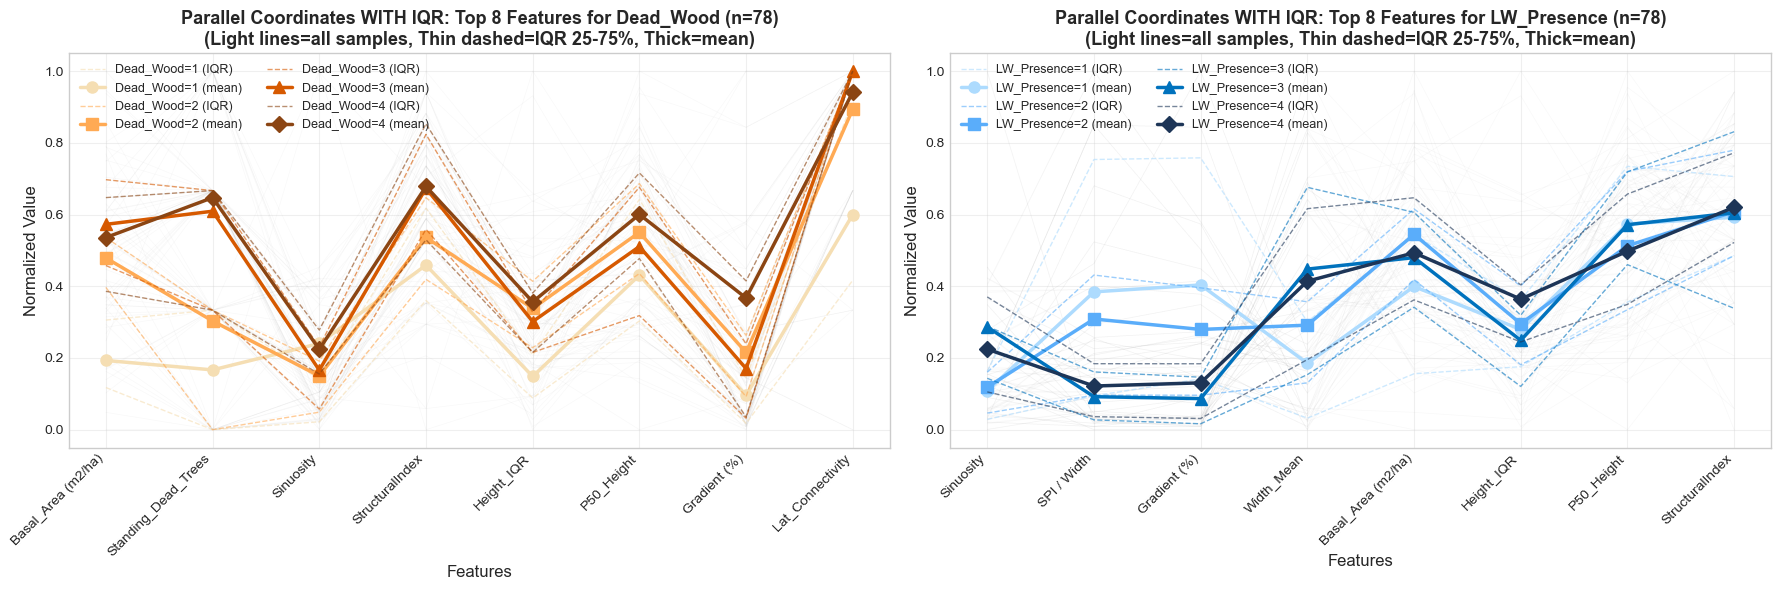


Parallel Coordinates WITH IQR Lines:
- Light gray lines: Individual samples
- Thin dashed lines: 25th and 75th percentile bounds (same color as mean)
- Thick lines: Mean values for each category
- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)


In [ ]:
# Parallel Coordinates Plot WITH IQR BANDS - Dead_Wood and LW_Presence
# Same as above but includes IQR (25-75%) as thin lines (no fill) in same color as mean

markers = {1: 'o', 2: 's', 3: '^', 4: 'D'}

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_sets = [
    ('Dead_Wood', prep_data_normalized_dw, 'Dead_Wood_Category', top_8_features_for_dw),
    ('LW_Presence', prep_data_normalized_lw, 'LW_Presence_Category', top_8_features_for_lw)
]

for idx, (target_name, data, category_col, features) in enumerate(data_sets):
    ax = axes[idx]
    n_samples = len(data)
    
    # Select color palette based on target variable
    color_palette = dw_class_colors if target_name == 'Dead_Wood' else lw_class_colors
    
    # Plot individual samples (light lines)
    for _, row in data.iterrows():
        positions = np.arange(len(features))
        values = [row[feat] for feat in features]
        ax.plot(positions, values, alpha=0.05, color='gray', linewidth=0.5)
    
    # Plot mean profiles with IQR thin lines
    for category in sorted(list(data[category_col].unique()), key=int):
        subset = data[data[category_col] == category]
        positions = np.arange(len(features))
        
        # Calculate mean and IQR for each feature
        mean_values = []
        q25_values = []
        q75_values = []
        
        for feat in features:
            mean_values.append(subset[feat].mean())
            q25_values.append(subset[feat].quantile(0.25))
            q75_values.append(subset[feat].quantile(0.75))
        
        cat_int = int(category)
        cat_color = color_palette[cat_int]
        
        # Plot Q25 and Q75 as thin lines with same color as mean
        ax.plot(positions, q25_values, linewidth=1, color=cat_color, alpha=0.6, linestyle='--')
        ax.plot(positions, q75_values, linewidth=1, color=cat_color, alpha=0.6, linestyle='--', label=f'{target_name}={cat_int} (IQR)')
        
        # Plot mean line on top with distinct marker per category
        ax.plot(positions, mean_values, linewidth=2.5, marker=markers[cat_int], 
                label=f'{target_name}={cat_int} (mean)', markersize=8, color=cat_color)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.set_title(f'Parallel Coordinates WITH IQR: Top 8 Features for {target_name} (n={n_samples})\n(Light lines=all samples, Thin dashed=IQR 25-75%, Thick=mean)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.legend(fontsize=9, loc='upper left', ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nParallel Coordinates WITH IQR Lines:")
print("- Light gray lines: Individual samples")
print("- Thin dashed lines: 25th and 75th percentile bounds (same color as mean)")
print("- Thick lines: Mean values for each category")
print("- Marker symbols: 1=circle (o), 2=square (s), 3=triangle (^), 4=diamond (D)")

Dead_Wood: Top 8 Features
  1. Standing_Dead_Trees
  2. Basal_Area (m2/ha)
  3. Height_IQR
  4. Sinuosity
  5. StructuralIndex


C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

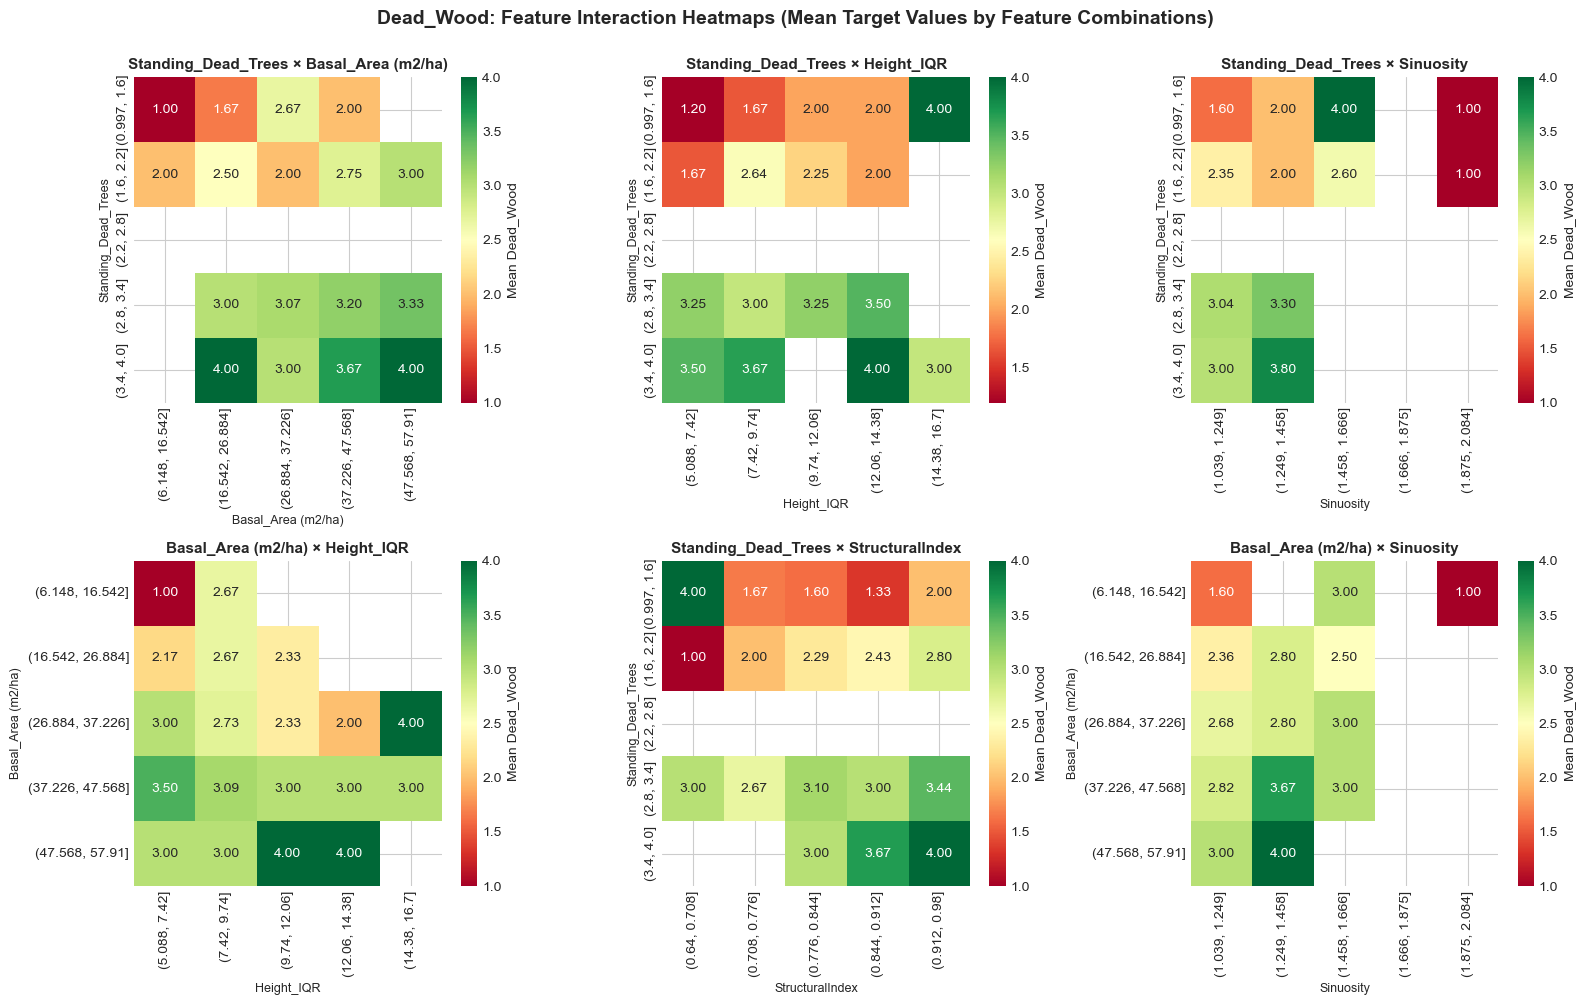



LW_Presence: Top 8 Features
  1. Sinuosity
  2. SPI / Width
  3. Gradient (%)
  4. Height_IQR
  5. Basal_Area (m2/ha)


C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_35304\778875256.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

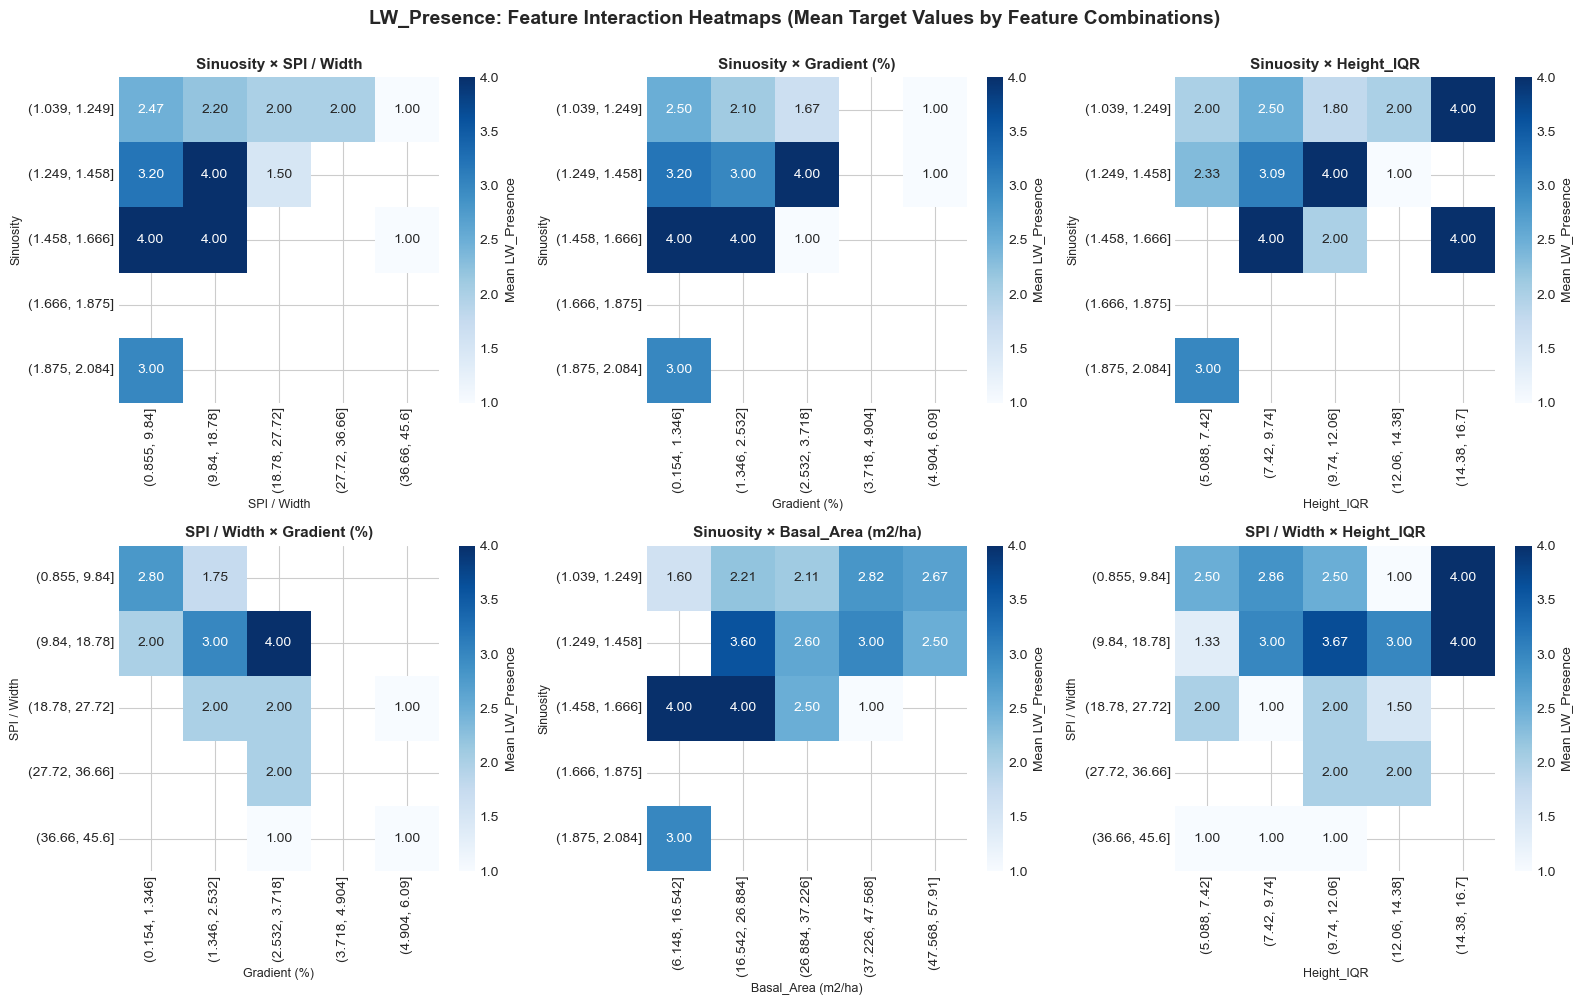


Interpretation: Each heatmap shows how two features interact to predict the target value.
Brighter colors = higher target values. Look for diagonal or off-diagonal patterns.
Cells with few samples are less reliable (visible as gaps in the grid).


In [ ]:
# 2D Heatmaps: 6 Feature Pair Combinations for each Target Variable
# Show how target value distribution changes with different feature combinations
# Feature pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4

n_bins = 5

# Helper function to create heatmap
def create_feature_heatmap(data, feat1, feat2, target_col, target_name, ax, cmap='RdYlGn'):
    """Create a heatmap for two feature combinations"""
    data_subset = data[[feat1, feat2, target_col]].dropna()
    
    if len(data_subset) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return
    
    feat1_bins = pd.cut(data_subset[feat1], bins=n_bins)
    feat2_bins = pd.cut(data_subset[feat2], bins=n_bins)
    
    contingency = data_subset.groupby([feat1_bins, feat2_bins])[target_col].agg(['mean', 'count'])
    pivot = contingency['mean'].unstack()
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                cbar_kws={'label': f'Mean {target_name}'})
    ax.set_title(f'{feat1} × {feat2}', fontsize=11, fontweight='bold')
    ax.set_xlabel(feat2, fontsize=9)
    ax.set_ylabel(feat1, fontsize=9)

# ============= DEAD_WOOD: 6 Feature Pairs =============
print("Dead_Wood: Top 8 Features")
print(f"  1. {top_8_features_dw[0]}")
print(f"  2. {top_8_features_dw[1]}")
print(f"  3. {top_8_features_dw[2]}")
print(f"  4. {top_8_features_dw[3]}")
print(f"  5. {top_8_features_dw[4]}")

fig_dw, axes_dw = plt.subplots(2, 3, figsize=(16, 10))
axes_dw = axes_dw.flatten()
n_dw_heatmap = len(df_dead_wood.dropna(subset=['Dead_Wood'] + top_8_features_dw[:5]))

# Feature pairs for Dead_Wood: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_dw = [
    (top_8_features_dw[0], top_8_features_dw[1], 'Features 1-2'),
    (top_8_features_dw[0], top_8_features_dw[2], 'Features 1-3'),
    (top_8_features_dw[0], top_8_features_dw[3], 'Features 1-4'),
    (top_8_features_dw[1], top_8_features_dw[2], 'Features 2-3'),
    (top_8_features_dw[0], top_8_features_dw[4], 'Features 1-5'),
    (top_8_features_dw[1], top_8_features_dw[3], 'Features 2-4'),
]

for idx, (feat1, feat2, label) in enumerate(feature_pairs_dw):
    create_feature_heatmap(df_dead_wood, feat1, feat2, 'Dead_Wood', 'Dead_Wood', 
                          axes_dw[idx], cmap='RdYlGn')

fig_dw.suptitle(f'Dead_Wood: Feature Interaction Heatmaps (n={n_dw_heatmap})\n(Mean Target Values by Feature Combinations)', 
                 fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============= LW_PRESENCE: 6 Feature Pairs =============
print("\n\nLW_Presence: Top 8 Features")
print(f"  1. {top_8_features_lw[0]}")
print(f"  2. {top_8_features_lw[1]}")
print(f"  3. {top_8_features_lw[2]}")
print(f"  4. {top_8_features_lw[3]}")
print(f"  5. {top_8_features_lw[4]}")

fig_lw, axes_lw = plt.subplots(2, 3, figsize=(16, 10))
axes_lw = axes_lw.flatten()
n_lw_heatmap = len(df_lw.dropna(subset=['LW_Presence'] + top_8_features_lw[:5]))

# Feature pairs for LW_Presence: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_lw = [
    (top_8_features_lw[0], top_8_features_lw[1], 'Features 1-2'),
    (top_8_features_lw[0], top_8_features_lw[2], 'Features 1-3'),
    (top_8_features_lw[0], top_8_features_lw[3], 'Features 1-4'),
    (top_8_features_lw[1], top_8_features_lw[2], 'Features 2-3'),
    (top_8_features_lw[0], top_8_features_lw[4], 'Features 1-5'),
    (top_8_features_lw[1], top_8_features_lw[3], 'Features 2-4'),
]

for idx, (feat1, feat2, label) in enumerate(feature_pairs_lw):
    create_feature_heatmap(df_lw, feat1, feat2, 'LW_Presence', 'LW_Presence', 
                          axes_lw[idx], cmap='Blues')

fig_lw.suptitle(f'LW_Presence: Feature Interaction Heatmaps (n={n_lw_heatmap})\n(Mean Target Values by Feature Combinations)', 
                 fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nInterpretation: Each heatmap shows how two features interact to predict the target value.")
print(f"Brighter colors = higher target values. Look for diagonal or off-diagonal patterns.")
print(f"Cells with few samples are less reliable (visible as gaps in the grid).")

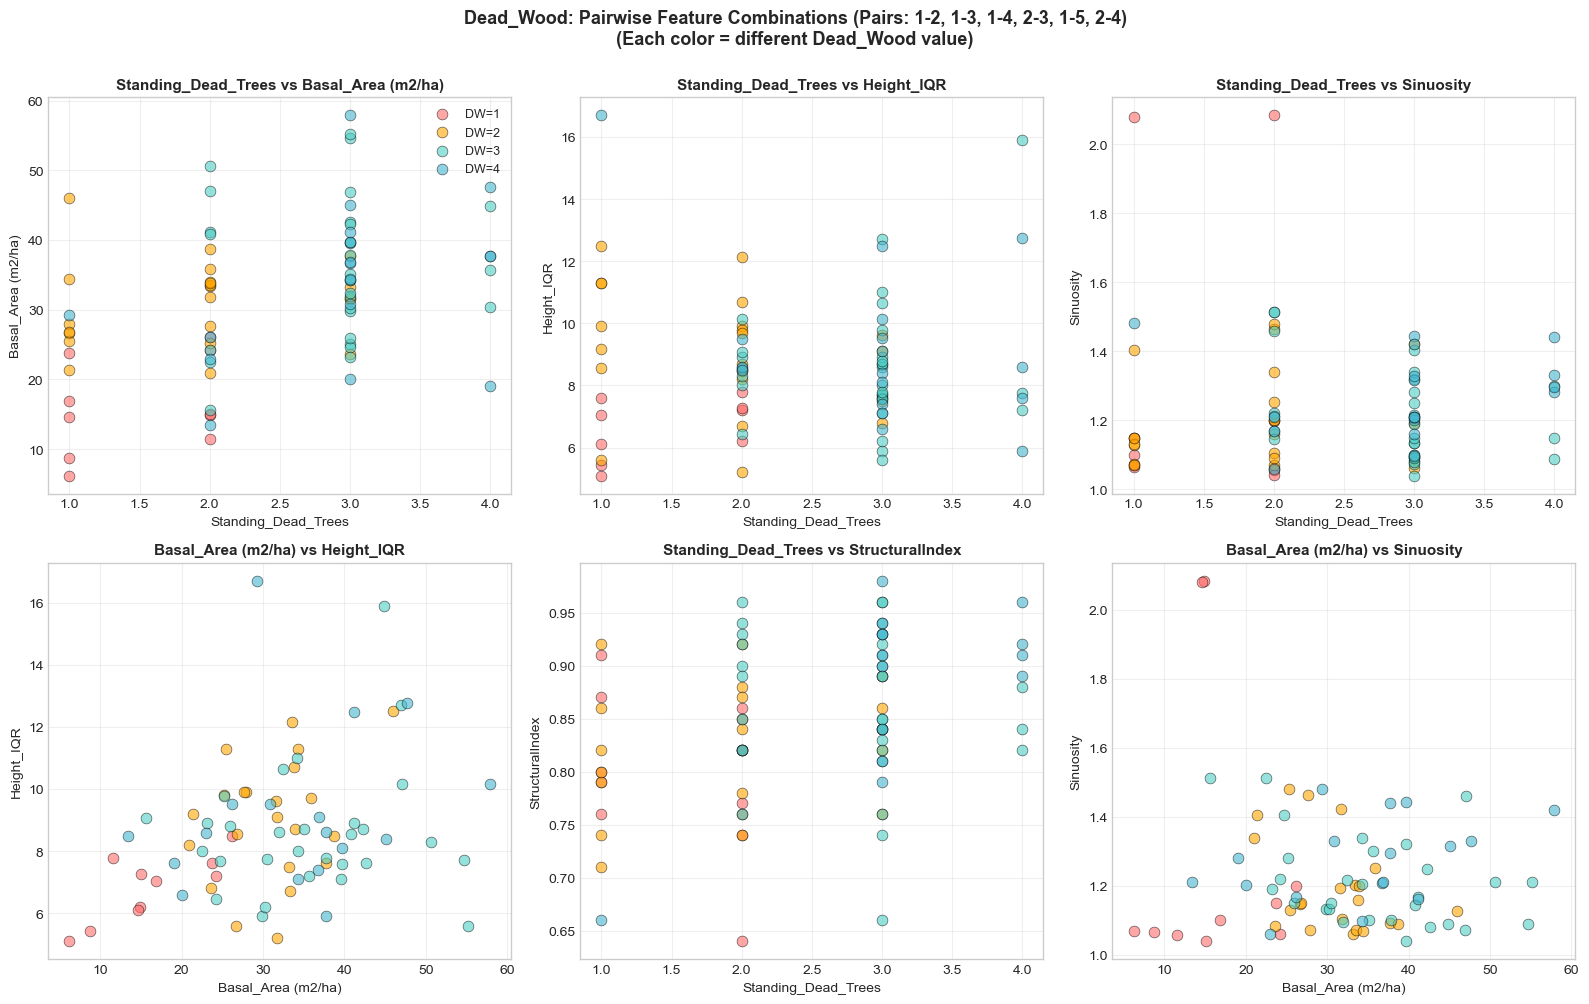

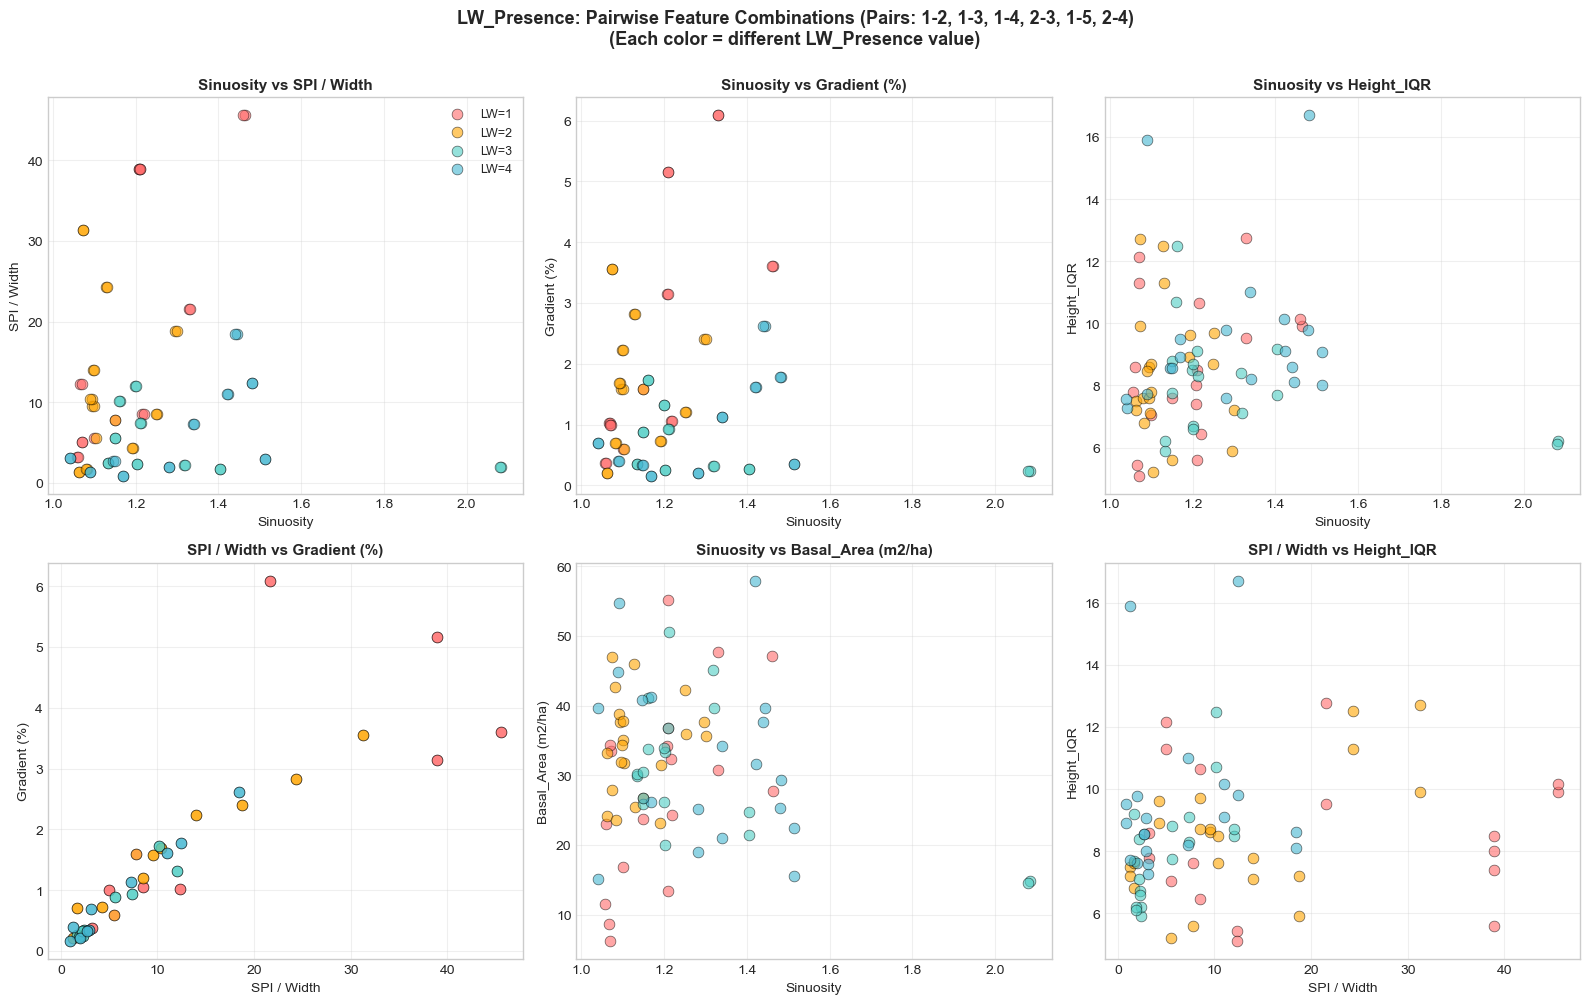


Interpretation: Each colored cluster represents samples with a specific target value.
Pairs are now consistent with the heatmaps: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
If clusters are well-separated, those feature combinations are predictive of the target.


In [ ]:
# Pairwise Scatter Plots - Specific feature pair combinations (1-2, 1-3, 1-4, 2-3, 1-5, 2-4)
# Colored by target value to see which combinations lead to which targets

# ============= DEAD_WOOD: 6 Feature Pairs =============
# Prepare data with top 5 features (subset needed for the 6 feature pairs)
top_5_dw_features = top_8_features_dw[:5]
top_5_dw_data = df_dead_wood[top_5_dw_features + ['Dead_Wood_Category']].dropna()
n_dw_pairs = len(top_5_dw_data)

# Define the 6 feature pair combinations: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_dw = [
    (top_8_features_dw[0], top_8_features_dw[1]),
    (top_8_features_dw[0], top_8_features_dw[2]),
    (top_8_features_dw[0], top_8_features_dw[3]),
    (top_8_features_dw[1], top_8_features_dw[2]),
    (top_8_features_dw[0], top_8_features_dw[4]),
    (top_8_features_dw[1], top_8_features_dw[3]),
]

fig_dw, axes_dw = plt.subplots(2, 3, figsize=(16, 10))
axes_dw = axes_dw.flatten()

colors_map = {'1': '#FF6B6B', '2': '#FFA500', '3': '#4ECDC4', '4': '#45B7D1'}

for idx, (feat1, feat2) in enumerate(feature_pairs_dw):
    ax = axes_dw[idx]
    for target_val in ['1', '2', '3', '4']:
        subset = top_5_dw_data[top_5_dw_data['Dead_Wood_Category'] == target_val]
        ax.scatter(subset[feat1], subset[feat2], label=f'DW={target_val}', 
                  alpha=0.6, s=60, color=colors_map[target_val], edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(feat1, fontsize=10)
    ax.set_ylabel(feat2, fontsize=10)
    ax.set_title(f'{feat1} vs {feat2}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)

fig_dw.suptitle(f'Dead_Wood: Pairwise Feature Combinations (n={n_dw_pairs})\n(Pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4 | Each color = different Dead_Wood value)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============= LW_PRESENCE: 6 Feature Pairs =============
# Prepare data with top 5 features
top_5_lw_features = top_8_features_lw[:5]
top_5_lw_data = df_lw[top_5_lw_features + ['LW_Presence_Category']].dropna()
n_lw_pairs = len(top_5_lw_data)

# Define the same 6 feature pair combinations: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4
feature_pairs_lw = [
    (top_8_features_lw[0], top_8_features_lw[1]),
    (top_8_features_lw[0], top_8_features_lw[2]),
    (top_8_features_lw[0], top_8_features_lw[3]),
    (top_8_features_lw[1], top_8_features_lw[2]),
    (top_8_features_lw[0], top_8_features_lw[4]),
    (top_8_features_lw[1], top_8_features_lw[3]),
]

fig_lw, axes_lw = plt.subplots(2, 3, figsize=(16, 10))
axes_lw = axes_lw.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs_lw):
    ax = axes_lw[idx]
    for target_val in ['1', '2', '3', '4']:
        subset = top_5_lw_data[top_5_lw_data['LW_Presence_Category'] == target_val]
        ax.scatter(subset[feat1], subset[feat2], label=f'LW={target_val}', 
                  alpha=0.6, s=60, color=colors_map[target_val], edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(feat1, fontsize=10)
    ax.set_ylabel(feat2, fontsize=10)
    ax.set_title(f'{feat1} vs {feat2}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)

fig_lw.suptitle(f'LW_Presence: Pairwise Feature Combinations (n={n_lw_pairs})\n(Pairs: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4 | Each color = different LW_Presence value)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nInterpretation: Each colored cluster represents samples with a specific target value.")
print(f"Pairs are now consistent with the heatmaps: 1-2, 1-3, 1-4, 2-3, 1-5, 2-4")
print(f"If clusters are well-separated, those feature combinations are predictive of the target.")

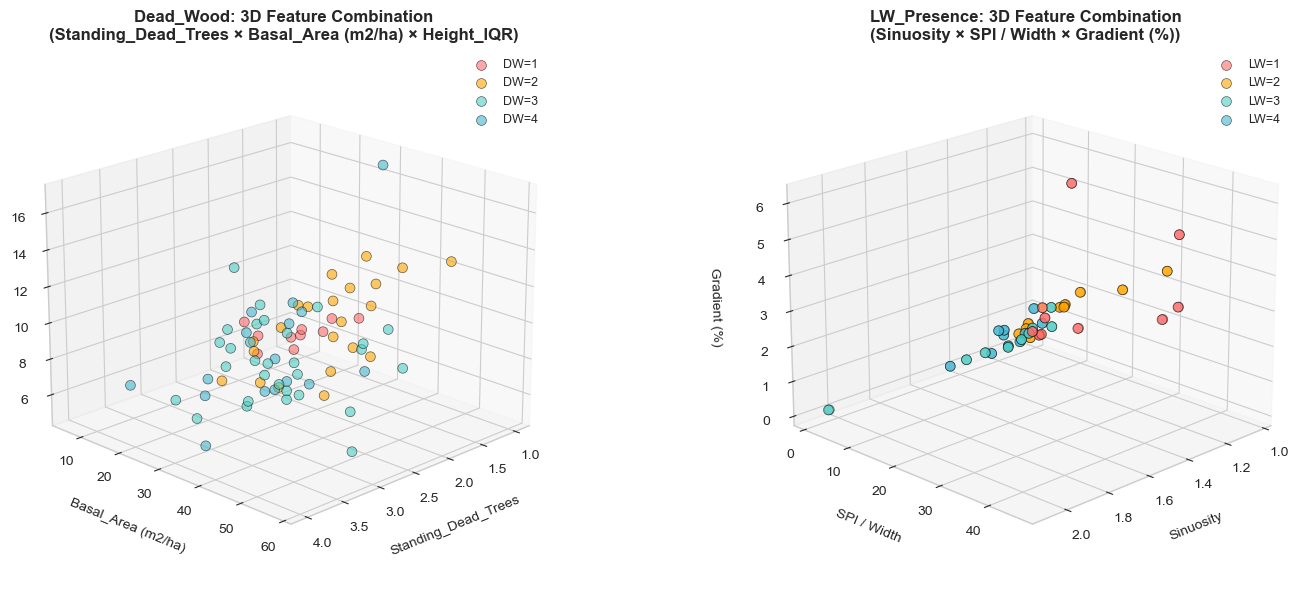


Interpretation: This 3D view shows how three features together determine the target value.
Well-separated colored clusters indicate that this 3-way combination is highly predictive.


In [ ]:
# 3D Scatter Plots - Three-way feature interactions
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Dead_Wood: 3D plot with top 3 features
ax1 = fig.add_subplot(121, projection='3d')
top_3_dw = top_8_features_dw[:3]
data_3d_dw = df_dead_wood[top_3_dw + ['Dead_Wood_Category']].dropna()
n_dw_3d = len(data_3d_dw)

for target_val, color in zip(['1', '2', '3', '4'], ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']):
    subset = data_3d_dw[data_3d_dw['Dead_Wood_Category'] == target_val]
    ax1.scatter(subset[top_3_dw[0]], subset[top_3_dw[1]], subset[top_3_dw[2]], 
               label=f'DW={target_val}', alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)

ax1.set_xlabel(top_3_dw[0], fontsize=10, labelpad=10)
ax1.set_ylabel(top_3_dw[1], fontsize=10, labelpad=10)
ax1.set_zlabel(top_3_dw[2], fontsize=10, labelpad=10)
ax1.set_title(f'Dead_Wood: 3D Feature Combination (n={n_dw_3d})\n({top_3_dw[0]} × {top_3_dw[1]} × {top_3_dw[2]})', 
             fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.view_init(elev=20, azim=45)

# LW_Presence: 3D plot with top 3 features
ax2 = fig.add_subplot(122, projection='3d')
top_3_lw = top_8_features_lw[:3]
data_3d_lw = df_lw[top_3_lw + ['LW_Presence_Category']].dropna()
n_lw_3d = len(data_3d_lw)

for target_val, color in zip(['1', '2', '3', '4'], ['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1']):
    subset = data_3d_lw[data_3d_lw['LW_Presence_Category'] == target_val]
    ax2.scatter(subset[top_3_lw[0]], subset[top_3_lw[1]], subset[top_3_lw[2]], 
               label=f'LW={target_val}', alpha=0.6, s=50, color=color, edgecolors='black', linewidth=0.5)

ax2.set_xlabel(top_3_lw[0], fontsize=10, labelpad=10)
ax2.set_ylabel(top_3_lw[1], fontsize=10, labelpad=10)
ax2.set_zlabel(top_3_lw[2], fontsize=10, labelpad=10)
ax2.set_title(f'LW_Presence: 3D Feature Combination (n={n_lw_3d})\n({top_3_lw[0]} × {top_3_lw[1]} × {top_3_lw[2]})', 
             fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\nInterpretation: This 3D view shows how three features together determine the target value.")
print(f"Well-separated colored clusters indicate that this 3-way combination is highly predictive.")

In [ ]:
# Feature Interaction Summary: Identify key combinations
print("\n" + "="*80)
print("SUMMARY: Key Feature Combinations and Interpretations")
print("="*80)

print("\n--- DEAD_WOOD: Best Feature Combinations ---")
print(f"\nPrimary Driver: {top_8_features_dw[0]} (Importance: {dw_importance[top_8_features_dw[0]]:.4f})")
print(f"Secondary Driver: {top_8_features_dw[1]} (Importance: {dw_importance[top_8_features_dw[1]]:.4f})")
print(f"Tertiary Factor: {top_8_features_dw[2]} (Importance: {dw_importance[top_8_features_dw[2]]:.4f})")

print(f"\nTop Feature Interaction Profiles for Dead_Wood:")
for target_val in [1, 2, 3, 4]:
    subset = df_dead_wood[df_dead_wood['Dead_Wood_Category'] == str(target_val)]
    if len(subset) > 0:
        print(f"\n  Dead_Wood = {target_val} (n={len(subset)} samples):")
        feat1_range = subset[top_8_features_dw[0]].agg(['min', 'mean', 'max'])
        feat2_range = subset[top_8_features_dw[1]].agg(['min', 'mean', 'max'])
        print(f"    {top_8_features_dw[0]}: [{feat1_range['min']:.2f} - {feat1_range['max']:.2f}] (mean: {feat1_range['mean']:.2f})")
        print(f"    {top_8_features_dw[1]}: [{feat2_range['min']:.2f} - {feat2_range['max']:.2f}] (mean: {feat2_range['mean']:.2f})")

print("\n" + "-"*80)
print("\n--- LW_PRESENCE: Best Feature Combinations ---")
print(f"\nPrimary Driver: {top_8_features_lw[0]} (Importance: {lw_importance[top_8_features_lw[0]]:.4f})")
print(f"Secondary Driver: {top_8_features_lw[1]} (Importance: {lw_importance[top_8_features_lw[1]]:.4f})")
print(f"Tertiary Factor: {top_8_features_lw[2]} (Importance: {lw_importance[top_8_features_lw[2]]:.4f})")

print(f"\nTop Feature Interaction Profiles for LW_Presence:")
for target_val in [1, 2, 3, 4]:
    subset = df_lw[df_lw['LW_Presence_Category'] == str(target_val)]
    if len(subset) > 0:
        print(f"\n  LW_Presence = {target_val} (n={len(subset)} samples):")
        feat1_range = subset[top_8_features_lw[0]].agg(['min', 'mean', 'max'])
        feat2_range = subset[top_8_features_lw[1]].agg(['min', 'mean', 'max'])
        print(f"    {top_8_features_lw[0]}: [{feat1_range['min']:.2f} - {feat1_range['max']:.2f}] (mean: {feat1_range['mean']:.2f})")
        print(f"    {top_8_features_lw[1]}: [{feat2_range['min']:.2f} - {feat2_range['max']:.2f}] (mean: {feat2_range['mean']:.2f})")

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("""
The visualizations above reveal:

1. PARALLEL COORDINATES: Shows how individual samples flow through feature space
   - Thick mean lines show the "typical profile" for each target value
   - Well-separated profiles indicate strong predictability

2. 2D HEATMAPS: Show which combinations of two features are associated with high/low targets
   - Cells with both darker and higher values = strong feature combinations
   - These represent synergistic effects (not just additive)

3. PAIRWISE SCATTERS: Colored by target, show if feature pairs cleanly separate targets
   - Well-separated clusters = feature pair is predictive
   - Overlapping clusters = feature pair alone is insufficient

4. 3D SCATTER: Shows how three features together define target categories
   - Spatial clustering indicates feature combinations drive target values
   - Can be rotated to explore different viewing angles
""")


SUMMARY: Key Feature Combinations and Interpretations

--- DEAD_WOOD: Best Feature Combinations ---

Primary Driver: Standing_Dead_Trees (Importance: 0.2515)
Secondary Driver: Basal_Area (m2/ha) (Importance: 0.1906)
Tertiary Factor: Height_IQR (Importance: 0.1204)

Top Feature Interaction Profiles for Dead_Wood:

  Dead_Wood = 1 (n=10 samples):
    Standing_Dead_Trees: [1.00 - 2.00] (mean: 1.50)
    Basal_Area (m2/ha): [6.20 - 26.15] (mean: 16.18)

  Dead_Wood = 2 (n=22 samples):
    Standing_Dead_Trees: [1.00 - 3.00] (mean: 1.91)
    Basal_Area (m2/ha): [20.95 - 45.95] (mean: 30.96)

  Dead_Wood = 3 (n=29 samples):
    Standing_Dead_Trees: [2.00 - 4.00] (mean: 2.86)
    Basal_Area (m2/ha): [15.60 - 55.15] (mean: 35.81)

  Dead_Wood = 4 (n=17 samples):
    Standing_Dead_Trees: [1.00 - 4.00] (mean: 2.94)
    Basal_Area (m2/ha): [13.40 - 57.91] (mean: 33.91)

--------------------------------------------------------------------------------

--- LW_PRESENCE: Best Feature Combinations ---


In [ ]:
# Inspect new CSV file: RV_For_RF2_n_1.csv
df_n_1 = pd.read_csv('data/RV_For_RF2_n_1.csv')
print(f"Shape: {df_n_1.shape}")
print(f"\nAll column names ({len(df_n_1.columns)} total):")
print(df_n_1.columns.tolist())

print(f"\n\n=== NEW COLUMNS ===")
new_cols = [col for col in df_n_1.columns if col.startswith('D_') or col.startswith('UP_') or 'Basin' in col or 'Bank' in col or 'Headwater' in col]
print(new_cols)

print(f"\n\n=== Basin values ===")
print(df_n_1['Basin'].unique() if 'Basin' in df_n_1.columns else 'Basin not found')

print(f"\n\n=== First few rows ===")
print(df_n_1.head(3))

FileNotFoundError: [Errno 2] No such file or directory: 'data/RV_For_RF2_n_1.csv'

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Length Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined